# Advanced Regression Techniques

A playground competition hosted by Kaggle to test advanced regression techniques. This notebook serves as a reference for various techniques used to approach and solve regression machine learning problems.

By Wong Tran <br>

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as pyo
import plotly.figure_factory as ff
import seaborn as sns
from scipy.stats import probplot, norm, skew, ttest_ind_from_stats, t, boxcox
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Lasso, LassoLarsCV, LassoLarsIC, LassoCV, ElasticNetCV, ElasticNet, Lars
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from learning_curve import plot_learning_curve, compute_learning_curve
from categorical_transformer import CatTransformer
from sklearn.feature_selection import RFECV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from statsmodels.stats.outliers_influence import OLSInfluence
from sklearn.metrics import mean_squared_error

<br>
<br>

# Contents

- [Initial Data Analysis](#Initial-Data-Analysis)
    - [Read in the data](#Read-in-the-data)
    - [Deal with missing data](#Deal-with-missing-data)
    - [Full missing data transformer](#Full-missing-data-transformer)
    - [Full categorical features transformer](#Full-categorical-features-transformer)
- [Exploratory Data Analysis](#Exploratory-data-analysis)
    - [Target variable](#Target-variable)
    - [Numerical features](#Numerical-features)
    - [Categorical features](#Categorical-features)
    - [Scatterplot Matrix](#Scatterplot-Matrix)
- [First Linear Regression Model](#First-Linear-Regression-Model)
    - [Ordinary Least Squares](#Ordinary-Least-Squares)
    - [Feature selection](#Feature-selection)
        - [Sequential Feature Selection](#Sequential-Feature-Selection)
        - [Cross validated Lasso](#Cross-validated-Lasso)
        - [Random Forest Feature Importance](#Random-Forest-feature-importance)
- [Linear Regression with SFS chosen features](#Linear-Regression-with-SFS-chosen-features)
    - [Remove influential points](#Remove-influential-points)
    - [GLM and OLSR residual analysis](#GLM-and-OLSR-residual-analysis)
- [Feature selection with Lasso using Log response](#Feature-selection-with-Lasso-using-Log-response)
    - [Build model](#Build-model)
- [Feature selection with SFS using Log response](#Feature-selection-with-SFS-using-Log-response)
    - [Build model (SFS)](#Build-model-(SFS))
- [Other ML models](#Other-ML-models)

<br>
<br>

# Initial Data Analysis

<br>
<br>

## Read in the data

In [2]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
train_labels = train_df[['Id','SalePrice']]
all_data = train_df.append(test_df, sort=False)
all_data.drop('SalePrice', axis=1, inplace=True)

In [3]:
train_df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 81 entries, Id to SalePrice
dtypes: float64(3), int64(35), object(43)
memory usage: 678.7+ KB


1460/1459 entries (Train/Test)

In [4]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Data fields

A brief version of what is found in the "data description" file. 

**SalePrice**: the property's sale price in dollars. This is the target variable that you're trying to predict.<br>
**MSSubClass**: The building class<br>
**MSZoning**: The general zoning classification<br>
**LotFrontage**: Linear feet of street connected to property<br>
**LotArea**: Lot size in square feet<br>
**Street**: Type of road access<br>
**Alley**: Type of alley access<br>
**LotShape**: General shape of property<br>
**LandContour**: Flatness of the property<br>
**Utilities**: Type of utilities available<br>
**LotConfig**: Lot configuration<br>
**LandSlope**: Slope of property<br>
**Neighborhood**: Physical locations within Ames city limits<br>
**Condition1**: Proximity to main road or railroad<br>
**Condition2**: Proximity to main road or railroad (if a second is present)<br>
**BldgType**: Type of dwelling<br>
**HouseStyle**: Style of dwelling<br>
**OverallQual**: Overall material and finish quality<br>
**OverallCond**: Overall condition rating<br>
**YearBuilt**: Original construction date<br>
**YearRemodAdd**: Remodel date<br>
**RoofStyle**: Type of roof<br>
**RoofMatl**: Roof material<br>
**Exterior1st**: Exterior covering on house<br>
**Exterior2nd**: Exterior covering on house (if more than one material)<br>
**MasVnrType**: Masonry veneer type<br>
**MasVnrArea**: Masonry veneer area in square feet<br>
**ExterQual**: Exterior material quality<br>
**ExterCond**: Present condition of the material on the exterior<br>
**Foundation**: Type of foundation<br>
**BsmtQual**: Height of the basement<br>
**BsmtCond**: General condition of the basement<br>
**BsmtExposure**: Walkout or garden level basement walls<br>
**BsmtFinType1**: Quality of basement finished area<br>
**BsmtFinSF1**: Type 1 finished square feet<br>
**BsmtFinType2**: Quality of second finished area (if present)<br>
**BsmtFinSF2**: Type 2 finished square feet<br>
**BsmtUnfSF**: Unfinished square feet of basement area<br>
**TotalBsmtSF**: Total square feet of basement area<br>
**Heating**: Type of heating<br>
**HeatingQC**: Heating quality and condition<br>
**CentralAir**: Central air conditioning<br>
**Electrical**: Electrical system<br>
**1stFlrSF**: First Floor square feet<br>
**2ndFlrSF**: Second floor square feet<br>
**LowQualFinSF**: Low quality finished square feet (all floors)<br>
**GrLivArea**: Above grade (ground) living area square feet<br>
**BsmtFullBath**: Basement full bathrooms<br>
**BsmtHalfBath**: Basement half bathrooms<br>
**FullBath**: Full bathrooms above grade<br>
**HalfBath**: Half baths above grade<br>
**Bedroom**: Number of bedrooms above basement level<br>
**Kitchen**: Number of kitchens<br>
**KitchenQual**: Kitchen quality<br>
**TotRmsAbvGrd**: Total rooms above grade (does not include bathrooms)<br>
**Functional**: Home functionality rating<br>
**Fireplaces**: Number of fireplaces<br>
**FireplaceQu**: Fireplace quality<br>
**GarageType**: Garage location<br>
**GarageYrBlt**: Year garage was built<br>
**GarageFinish**: Interior finish of the garage<br>
**GarageCars**: Size of garage in car capacity<br>
**GarageArea**: Size of garage in square feet<br>
**GarageQual**: Garage quality<br>
**GarageCond**: Garage condition<br>
**PavedDrive**: Paved driveway<br>
**WoodDeckSF**: Wood deck area in square feet<br>
**OpenPorchSF**: Open porch area in square feet<br>
**EnclosedPorch**: Enclosed porch area in square feet<br>
**3SsnPorch**: Three season porch area in square feet<br>
**ScreenPorch**: Screen porch area in square feet<br>
**PoolArea**: Pool area in square feet<br>
**PoolQC**: Pool quality<br>
**Fence**: Fence quality<br>
**MiscFeature**: Miscellaneous feature not covered in other categories<br>
**MiscVal**: $Value of miscellaneous feature<br>
**MoSold**: Month Sold<br>
**YrSold**: Year Sold<br>
**SaleType**: Type of sale<br>
**SaleCondition**: Condition of sale<br>

**Observations**

- The features can be generally split into three categories, those that describe the house's **structure** (e.g. OverallQual, HouseStyle), **space** (e.g.LotArea, TotalBsmtSF) or **location** (e.g. LandSlope, Neighborhood)
- There are plenty of numerical and categorical features included in the dataset. The data is likely **overspecified** with plenty of **extraneous variables**. 
- The success of this regression problem will likely be down to appropriate **feature selection** and **feature engineering**.  

<br>
<br>

## Deal with missing data

In [3]:
feats = list(all_data.columns)
missing_data_df = pd.DataFrame(all_data[feats].isnull().sum().sort_values(ascending=False))
missing_data_df.rename(columns={0:'Total'}, inplace=True)
missing_data_df['%'] = np.round(missing_data_df['Total']/len(all_data), 4)*100
missing_data_df[missing_data_df['%']!=0]

,Total,%
PoolQC,2909,99.66
MiscFeature,2814,96.40
Alley,2721,93.22
Fence,2348,80.44
FireplaceQu,1420,48.65
LotFrontage,486,16.65
GarageCond,159,5.45
GarageQual,159,5.45
GarageYrBlt,159,5.45
GarageFinish,159,5.45


From the data description file, most of the missing data seems to be encoded to indicate the absence of a home feature. These missing data values will be filled in with either a "None" for categorical features, or 0 for numerical features.

For features where it is not clear that missing data has been pre-encoded, our first data preprocessing iteration will just fill in these missing values with the most appropriate central value. Later we can explore more sophisticated methods of data imputation (e.g. [MICE](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3074241/)) to see if it improves the performance of our models.

<br>
<br>

## Full missing data transformer

Combine all of the missing data handling steps into a single scikit-learn style transformer and import it from a script.

In [4]:
from missing_data import MissingDataImputer
missing_imputer = MissingDataImputer()
all_data = missing_imputer.fit_transform(all_data)

In [5]:
missing_data_df = pd.DataFrame(all_data[feats].isnull().sum().sort_values(ascending=False))
missing_data_df.rename(columns={0:'Total'}, inplace=True)
missing_data_df['%'] = np.round(missing_data_df['Total']/len(all_data), 4)*100
missing_data_df[missing_data_df['%']!=0]

,Total,%
LotFrontage,486,16.65


"LotFrontage" is a numerical feature where it is not clear from the data description file whether the missing data was encoded.
Since the feature is numrical, we will leave imputation till the end to prevent information leak whilst performing cross validation.

<br>
<br>

## Full categorical features transformer

One-hot-Encode nominal categorical variables and encode ordinal categorical variables with an appropriate ordered mapping.

In [8]:
# List categorical variables
all_data.select_dtypes(include=object).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 43 columns):
MSZoning         2919 non-null object
Street           2919 non-null object
Alley            2919 non-null object
LotShape         2919 non-null object
LandContour      2919 non-null object
Utilities        2919 non-null object
LotConfig        2919 non-null object
LandSlope        2919 non-null object
Neighborhood     2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
BldgType         2919 non-null object
HouseStyle       2919 non-null object
RoofStyle        2919 non-null object
RoofMatl         2919 non-null object
Exterior1st      2919 non-null object
Exterior2nd      2919 non-null object
MasVnrType       2919 non-null object
ExterQual        2919 non-null object
ExterCond        2919 non-null object
Foundation       2919 non-null object
BsmtQual         2919 non-null object
BsmtCond         2919 non-null object
BsmtExposure     29

In [9]:
ordinal_feats = ["Alley", "Utilities", "LandSlope", "LotShape", "LandContour", "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "HeatingQC", "KitchenQual", "Functional", "FireplaceQu", "GarageFinish", "GarageQual", "GarageCond", "PavedDrive", "PoolQC"]
nominal_feats = ["HouseStyle", "Street", "MSZoning", "LotConfig", "Neighborhood", "Condition1", "Condition2", "BldgType", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "Foundation", "Heating", "CentralAir", "Electrical", "GarageType", "Fence", "MiscFeature", "SaleType", "SaleCondition"]

From the data description file, there appears to be some numerical features that are actually categorical, namely:

- **MSSubCLass** - Identifies the type of dwelling involved in the sale
- **MoSold** - Month Sold
- **YrSold** - Year Sold
- **OverallQual** - Rates the overall material and finish of the house
- **OverallCond** - Rates the overall condition of the house

The first three are nominal categorical variables that have been pre-encoded to numerical values. These numerical values need to be treated as strings and one-hot encoded along with the rest of the nominal categorical features. 

OverallQual and OverallCond are ordinal and are already encoded in numerical format thus no mapping will be required.

We will again combine the categorical feature encoding steps into a single scikit-learn style transformer and import it from a separate script

In [10]:
cat_transf = CatTransformer()
all_data = cat_transf.fit_transform(all_data)

In [11]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Columns: 230 entries, Id to YrSold_2010
dtypes: float64(11), int64(44), uint8(175)
memory usage: 1.7 MB


In [12]:
len(cat_transf.all_feature_names)

230

After transforming all of the categorical variables, we have 230 features in total. 

<br>
<br>

# Exploratory data analysis

To perform EDA, we'll look at the training dataset after imputing missing values but without transforming categorical variables.

In [5]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
train_labels = train_df[['Id','SalePrice']]

In [6]:
from missing_data import MissingDataImputer
missing_imputer = MissingDataImputer()
train_df = missing_imputer.fit_transform(train_df)

<br>
<br>

## Target variable

Check normality of the target variable.

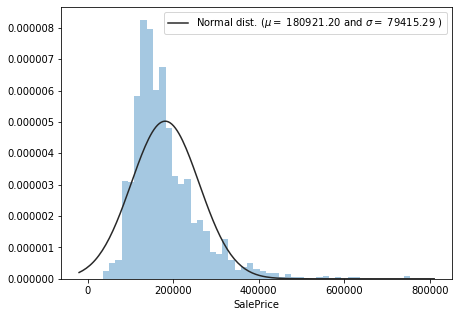

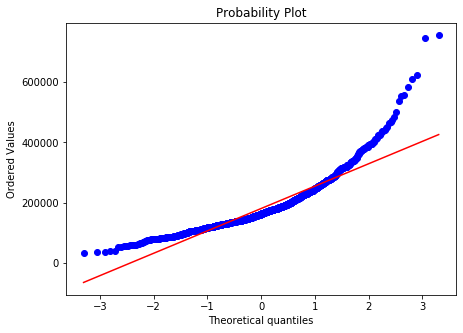

In [16]:
plt.figure(figsize=(7,5))
(mu,sigma) = norm.fit(train_labels['SalePrice'])
sns.distplot(train_labels['SalePrice'], fit=norm, kde=False)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')

plt.figure(figsize=(7,5))
probplot(train_labels['SalePrice'], plot=plt)
plt.show()

This normal probability plot indicates that the target variable is right skewed. SalePrice is bounded below at 0 and there are many houses which sell for a large amount.

Target variable transformations may have to be used to maintain the assumptions of a regression model but we will investigate this when evaluating our model.

<br>
<br>

## Numerical features

A good way to quickly visualise the linear associations and potential collinearity between all numerical features is a heatmap of correlations

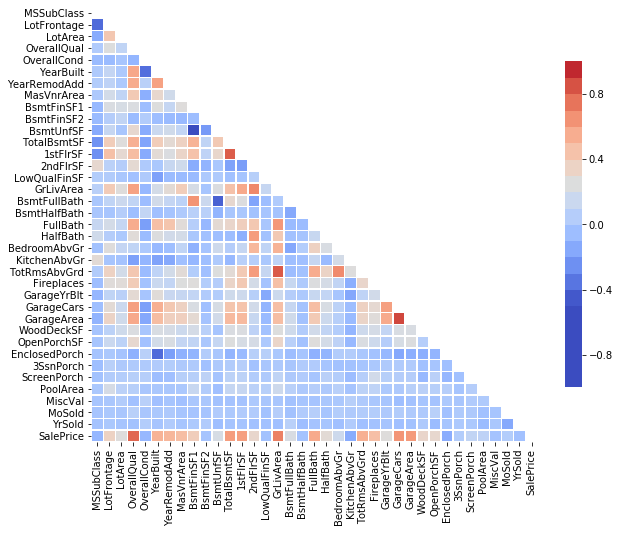

In [17]:
mask = np.zeros_like(train_df.iloc[:,1:].corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(10,8));
sns.heatmap(train_df.iloc[:,1:].corr(), linewidths=0.5, cmap='coolwarm', mask=mask,
            cbar_kws={'boundaries':np.linspace(-1,1, 21).tolist(),
                      'shrink':0.75});

**Observations**:

- There appears to be strong collinearity between 'GarageArea' and 'GarageCars' as well as between 'TotRmsAbvGrd' and 'GrLivArea', which makes sense as they are features which are linked and provide almost the same information. Pruning these features may be required to produce a more stable and interpretable model.
- Other features that are correlated include those that provide information about the size of a home as well as features that give information about the homes' capacity, for instance, the link between '1stFlrSF', 2ndFlrSf', 'GarageArea' etc.
- From the bottom rows, there appears to be several numerical features with a strong positive correlation with the target variable, particularly 'OverallQual', 'GrLivArea' as well as several indicators of a home's size.

<br>
<br>

## Categorical features

A feature that stands out from the correlation plot is "OverallQual" which appears to have a strong correlation with the target variable. Since it's an ordinal categorical variable, let's visualize this with a boxplot.

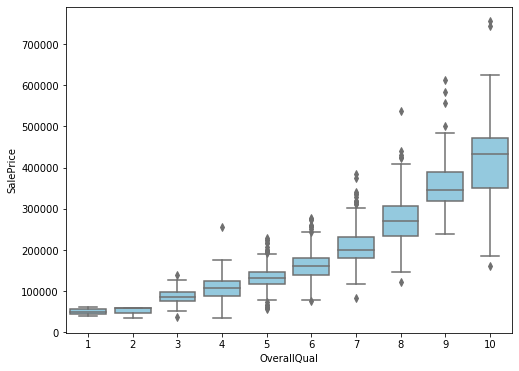

In [18]:
plt.figure(figsize=(8,6))
sns.boxplot(train_df['OverallQual'], train_df['SalePrice'], color='skyblue')

A strong positive correlation exists between 'OverallQual' (the overall material and finish of the house) and its sale price which seems pretty intuitive. The relationship doesn't seem to be linear and is heteroscedastic 

<br>
<br>

Let's visualize the relationship between the year a house was built and its Sale Price

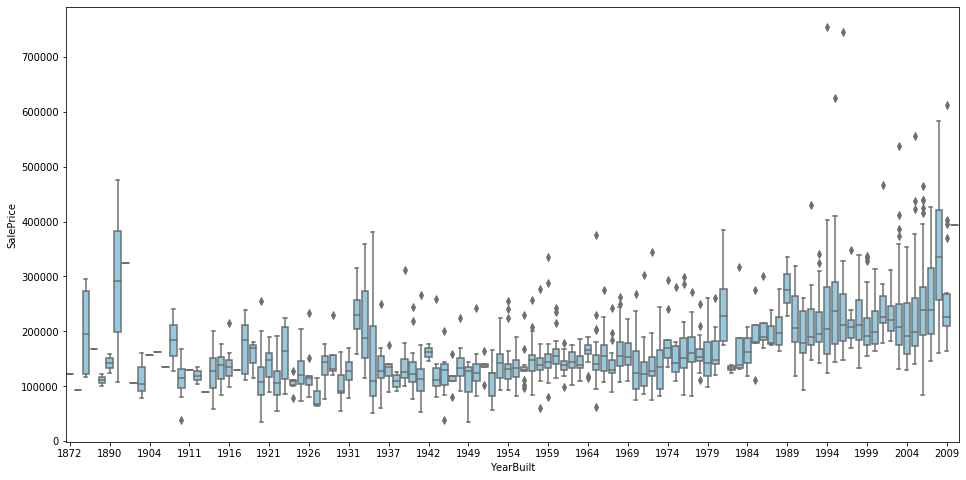

In [19]:
plt.figure(figsize=(16,8))
sns.boxplot(x='YearBuilt', y='SalePrice', data=train_df, color='skyblue')
loc, label = plt.xticks()
plt.xticks(loc[::5], label[::5]);

Although there are plenty of exceptions, in general, modern houses (e.g. those built within the last two decades of the dataset) sell for more.
We can easily verify this by checking the median sale price for two time periods.

In [20]:
print("Median sale price of homes built from 1989 onwards: ${}".format(train_df[train_df['YearBuilt']>=1989].SalePrice.median()))
print("Median sale price of homes built before 1989: ${}".format(train_df[train_df['YearBuilt']<1989].SalePrice.median()))

Median sale price of homes built from 1989 onwards: $215600.0
Median sale price of homes built before 1989: $137950.0


**Two-tailed difference of two means t-test**

In [19]:
ttest_ind_from_stats(mean1=train_df[train_df['YearBuilt']>=1989].SalePrice.mean(), 
                     std1=train_df[train_df['YearBuilt']>=1989].SalePrice.std(ddof=1), 
                     nobs1=len(train_df[train_df['YearBuilt']>=1989]), 
                     mean2=train_df[train_df['YearBuilt']<1989].SalePrice.mean(), 
                     std2=train_df[train_df['YearBuilt']<1989].SalePrice.std(ddof=1), 
                     nobs2=len(train_df[train_df['YearBuilt']<1989]), 
                     equal_var=False)

Ttest_indResult(statistic=23.303598658604265, pvalue=1.1541766399276009e-91)

The p-value is statistically significant at $\alpha=0.05$ significance level. The mean sale price of houses built before 1989 is statistically different and less than the mean sale price of houses built after 1989

<br>
<br>

Let's see if there is any seasonality in the relationship between the sale month of homes and their sale price 

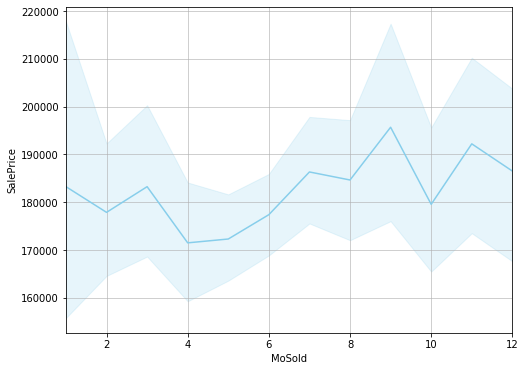

In [21]:
plt.figure(figsize=(8,6))
sns.lineplot(x='MoSold', y='SalePrice', data=train_df, color='skyblue', 
             estimator='mean', ci=95) # 1-sigma
plt.grid(alpha=0.75)
plt.xlim(1,12);

There is large variability in the sale price of homes with respect to the month it was sold, however, the first half of the year (Q1, Q2) seems to have slightly lower home sale prices compared to the second half (Q3, Q4). Let's verify this. 

In [22]:
print("Q1 and Q2 median home sale prices: ${}".format(train_df.loc[train_df['MoSold']<7].SalePrice.median()))
print("Q3 and Q4 median home sale prices: ${}".format(train_df.loc[train_df['MoSold']>=7].SalePrice.median()))

Q1 and Q2 median home sale prices: $158950.0
Q3 and Q4 median home sale prices: $170000.0


**Two-tailed difference of two means t-test**

In [21]:
from scipy.stats import ttest_ind_from_stats, t
ttest_ind_from_stats(mean1=train_df.loc[train_df['MoSold']<7].SalePrice.mean(), 
                     std1=train_df.loc[train_df['MoSold']<7].SalePrice.std(ddof=1), 
                     nobs1=len(train_df.loc[train_df['MoSold']<7]), 
                     mean2=train_df.loc[train_df['MoSold']>=7].SalePrice.mean(), 
                     std2=train_df.loc[train_df['MoSold']>=7].SalePrice.std(ddof=1), 
                     nobs2=len(train_df.loc[train_df['MoSold']>=7]), 
                     equal_var=False)

Ttest_indResult(statistic=-2.47298419419772, pvalue=0.01352266431182276)

The p-value is statistically significant at $\alpha=0.05$ significance level. The mean sale price of houses sold during the first half of the year is statistically different and less than the mean sale price of houses sold during the second half of the year.

<br>
<br>

## Scatterplot Matrix

Since there are too many numerical variables to visualize all at once, let's make a scatterplot matrix (pairplot) of numerical features that have a correlation greater than 0.5 between them and the target variable.

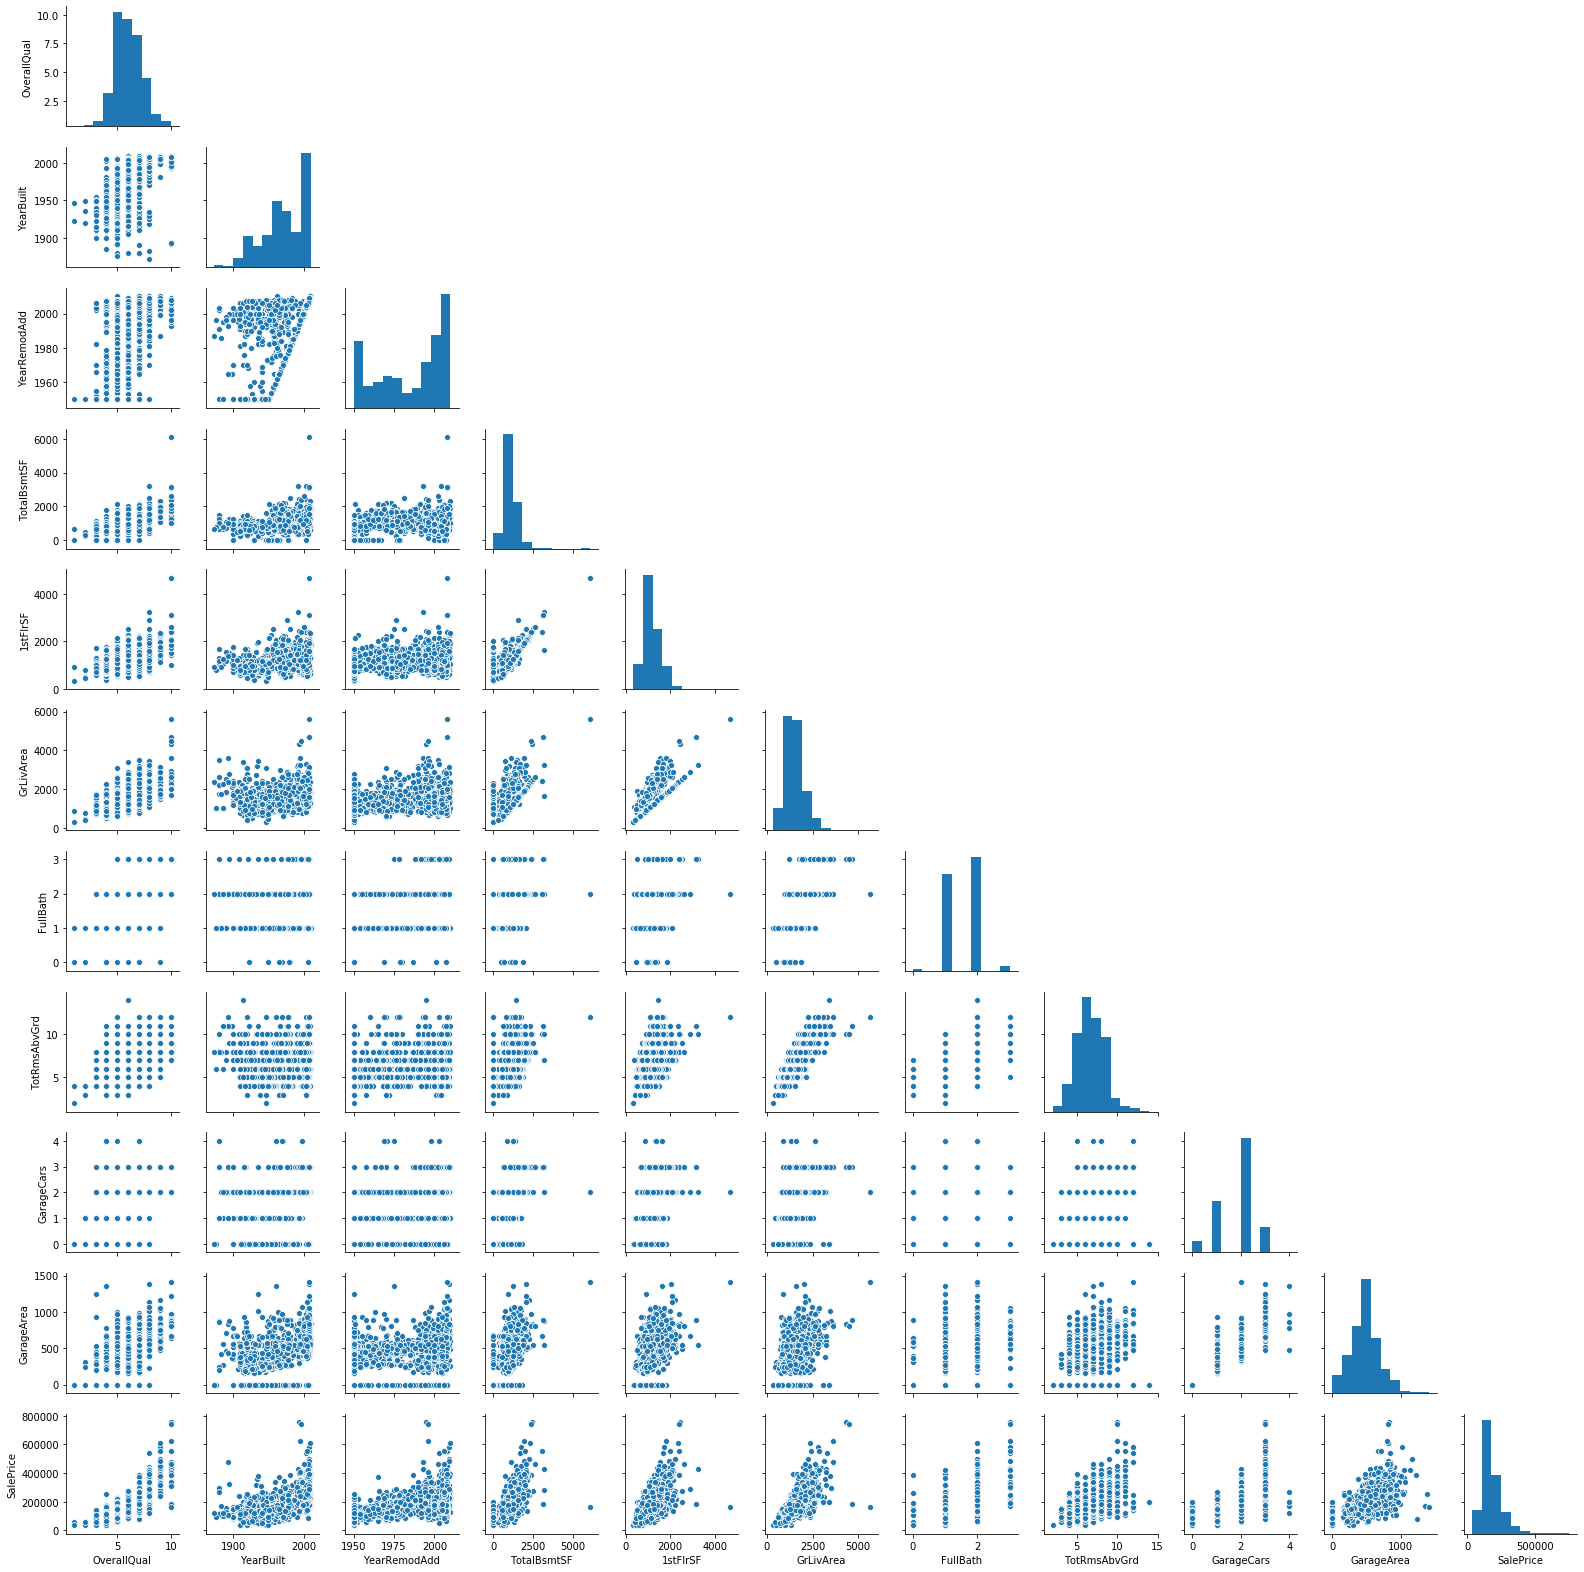

In [23]:
corr_saleprice = np.abs(train_df.corr()['SalePrice'])
feats05greater = corr_saleprice[corr_saleprice>0.5].index

g = sns.pairplot(train_df.loc[:,feats05greater], height=2)
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)
    
del(corr_saleprice)

Observations:

- The best numerical predictors of sale price are features that tell us information about the home's size, the number of rooms they have as well as the year they were built/remodelled. 

<br>
<br>

# First Linear Regression Model

In [2]:
# Import data

train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
train_labels = train_df[['Id','SalePrice']]
test_id = pd.DataFrame(test_df['Id'])
all_data = train_df.append(test_df, sort=False)
all_data.drop(columns='SalePrice', inplace=True)

# Impute missing values (excluding LotFrontage)
from missing_data import MissingDataImputer
missing_imputer = MissingDataImputer()
all_data = missing_imputer.fit_transform(all_data)

# Transform categorical variables
from categorical_transformer import CatTransformer
cat_transf = CatTransformer()
all_data = cat_transf.fit_transform(all_data)

# Create LotFrontage imputer
lotfrontage_imputer = MissingDataImputer(impute_lotfrontage=True)

train_df = all_data[all_data['Id'].isin(train_df['Id'])]
test_df = all_data[all_data['Id'].isin(test_df['Id'])]

train_df.drop(columns='Id', inplace=True)
test_df.drop(columns='Id', inplace=True)

<br>
<br>

## Ordinary Least Squares

In [3]:
train_df = SimpleImputer(strategy='median').fit_transform(train_df)
X_train_with_bias = sm.add_constant(train_df)  # Add feature of ones 
lin_regr = sm.OLS(train_labels['SalePrice'].values, X_train_with_bias).fit()

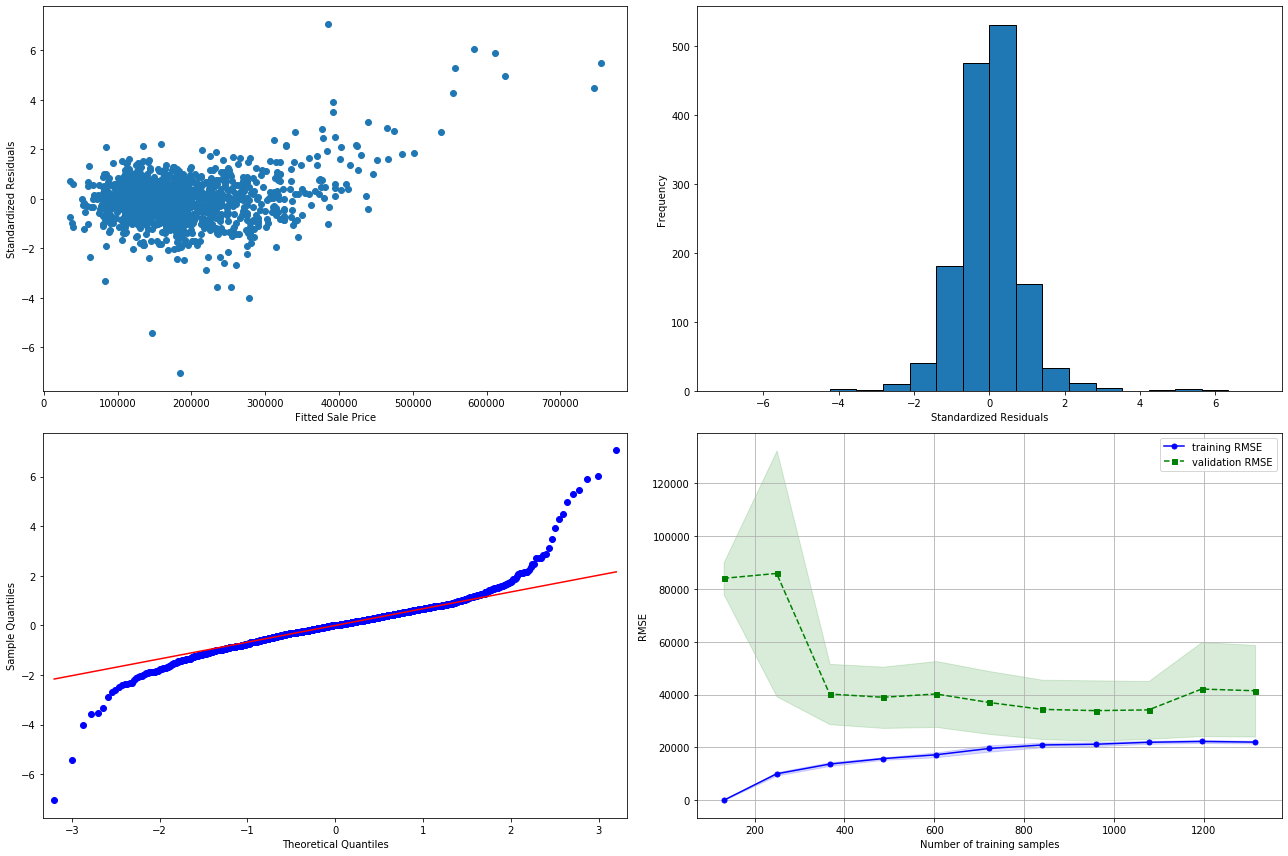

In [6]:
fig=plt.figure(figsize=(18,12))

ax1 = plt.subplot(221)
ax1.scatter(train_labels['SalePrice'].values, lin_regr.resid_pearson)
ax1.set_xlabel("Fitted Sale Price")
ax1.set_ylabel("Standardized Residuals")

ax2 = plt.subplot(222)
ax2.hist(lin_regr.resid_pearson, bins=20, edgecolor='k')
ax2.set_xlabel("Standardized Residuals")
ax2.set_ylabel("Frequency")

ax3 = plt.subplot(223)
fig = sm.qqplot(lin_regr.resid_pearson, line='q', ax=ax3)

ax4 = plt.subplot(224)
lin_regr_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')),
                          ('lin_regr', LinearRegression())])
lin_regr_pipe.fit(train_df, train_labels['SalePrice'])

lc_params = compute_learning_curve(estimator=lin_regr_pipe, 
                                X=train_df, 
                                y=train_labels['SalePrice'].values,
                                cv=10)
plot_learning_curve(ax4, lc_params)
plt.tight_layout()

**Observations**

- According to the $R^2$ there is a potentially strong linear association between the features and the response, ~92.0% of the variation in SalePrice is explained by the features.
- The residual plot shows a departure from linearity for high values of "SalePrice", indicating that a non-linear fit would be better. As a result of the non-linearity it is difficult to tell if the model is affected by heteroscedasticity
- The normal probability plot for the residuals indicate departure from normality in the high and low quartiles. This is indicative of a heavy-tailed distribution as can be seen in the histogram of residuals
- The learning curve shows that the model is performing better on the training set compared to the validation set which is an indication of **overfitting**. There is a bump in validation RMSE at around 1100 training samples, as a result it is not clear whether more data would improve the model.

In [6]:
vif_dict = {}
for idx, feat in enumerate(train_df.columns):
    vif_dict[feat] = variance_inflation_factor(X_train_with_bias, idx+1);
vif_series = pd.Series(vif_dict)
del(vif_dict)

c:\users\wongt\desktop\advanced_regression_techniques_conda\venv\lib\site-packages\statsmodels\stats\outliers_influence.py:185: RuntimeWarning:

divide by zero encountered in double_scalars

c:\users\wongt\desktop\advanced_regression_techniques_conda\venv\lib\site-packages\statsmodels\regression\linear_model.py:1636: RuntimeWarning:

invalid value encountered in double_scalars



In [8]:
vif_series.sort_values(ascending=False).head(30)

Exterior2nd_CBlock             inf
GrLivArea                      inf
LowQualFinSF                   inf
2ndFlrSF                       inf
BldgType_Duplex                inf
1stFlrSF                       inf
TotalBsmtSF                    inf
Exterior1st_CBlock             inf
BsmtUnfSF                      inf
BsmtFinSF2                     inf
BsmtFinSF1                     inf
MSSubClass_90                  inf
GarageYrBlt            2148.049979
GarageType_None        1994.406296
MiscFeature_None        967.664861
MiscFeature_Shed        807.269052
RoofStyle_Gable         159.439915
RoofStyle_Hip           147.939037
MSSubClass_20           139.645322
MSSubClass_60           121.934431
Exterior1st_VinylSd     113.648035
Exterior2nd_VinylSd     104.144515
GarageType_Attchd        81.433388
Exterior1st_MetalSd      75.306730
MSSubClass_50            70.899255
Exterior2nd_MetalSd      69.369170
GarageType_Detchd        65.309908
Exterior1st_HdBoard      58.618184
HouseStyle_1Story   

In accordance with our initial impressions of the data, there are many features in the dataset most of which have a high VIF (>15) indicating a large number of collinear features that provide the same information about the houses being sold.

We must perform variable selection to reduce the number of features before attempting any non-linear regression methods. This is to mitigate the possibility of overfitting when for example introducing non-linear and interaction features in order to tackle the non-linear trend in the data (as indicated by the residual plot).

<br>
<br>

## Feature selection

<br>
<br>

### Sequential Feature Selection

In [ ]:
feat_names = list(train_df.columns)
sfs_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')),
                     ('lin_regr', LinearRegression())])

sfs = SFS(sfs_pipe, 
          k_features='parsimonious', 
          forward=True, 
          floating=True, 
          verbose=2,
          scoring='neg_mean_squared_error',
          cv=5,
          n_jobs=4
         )

sfs = sfs.fit(train_df.values, train_labels['SalePrice'], custom_feature_names=feat_names)

In [56]:
print("Parsimonious SFS:\n")
print("{} features chosen by SFS\n".format(len(sfs.k_feature_names_)))
print("Selected features: {}\n".format(sfs.k_feature_names_))
print("Best score: {}".format(np.sqrt(-sfs.k_score_)))

Parsimonious SFS:

29 features chosen by SFS

Selected features: ('LotArea', 'OverallQual', 'OverallCond', 'GrLivArea', 'Fireplaces', 'GarageCars', 'WoodDeckSF', 'ScreenPorch', 'ExterQual', 'BsmtExposure', 'BsmtFinType1', 'KitchenQual', 'Functional', 'HouseStyle_2Story', 'LotConfig_CulDSac', 'Neighborhood_BrkSide', 'Neighborhood_Crawfor', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Condition1_Norm', 'RoofStyle_Hip', 'RoofMatl_WdShngl', 'Exterior1st_BrkFace', 'GarageType_None', 'SaleType_New', 'MSSubClass_20', 'MSSubClass_60')

Best score: 30338.49583463479


In [10]:
sfs_scores = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
sfs_scores.to_csv("data/sfs_df.csv", index=False)  # Save the SFS results
sfs_scores['RMSE'] = (-sfs_scores['avg_score'])**0.5

In [42]:
sfs_scores.sort_values('avg_score', ascending=False).head()

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,RMSE
84,"(1, 2, 3, 4, 9, 14, 15, 16, 17, 18, 19, 20, 21...","[-440678879.17026794, -889771180.8025004, -826...",-8.61737e+08,"(LotArea, OverallQual, OverallCond, YearBuilt,...",4.48135e+08,3.48664e+08,1.74332e+08,29355.4
85,"(1, 2, 3, 4, 9, 14, 15, 16, 17, 18, 19, 20, 21...","[-440678879.170296, -889771180.8026042, -82671...",-8.61737e+08,"(LotArea, OverallQual, OverallCond, YearBuilt,...",4.48135e+08,3.48664e+08,1.74332e+08,29355.4
86,"(1, 2, 3, 4, 9, 14, 15, 16, 17, 18, 19, 20, 21...","[-440678879.17023355, -890241337.8664689, -826...",-8.61766e+08,"(LotArea, OverallQual, OverallCond, YearBuilt,...",4.48159e+08,3.48683e+08,1.74341e+08,29355.9
87,"(1, 2, 3, 4, 9, 14, 15, 16, 17, 18, 19, 20, 21...","[-438335085.86457294, -888579457.4638133, -827...",-8.61799e+08,"(LotArea, OverallQual, OverallCond, YearBuilt,...",4.47118e+08,3.47873e+08,1.73937e+08,29356.4
88,"(1, 2, 3, 4, 9, 14, 15, 16, 17, 18, 19, 20, 21...","[-438335085.86455476, -889121987.4611645, -826...",-8.61836e+08,"(LotArea, OverallQual, OverallCond, YearBuilt,...",4.47075e+08,3.47839e+08,1.7392e+08,29357


Chosen parsimonious model

In [41]:
sfs_scores[sfs_scores['avg_score']==sfs.k_score_]

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,RMSE
29,"(1, 2, 3, 14, 22, 24, 26, 30, 38, 42, 43, 46, ...","[-498090438.6093986, -978074034.8905374, -9275...",-9.20424e+08,"(LotArea, OverallQual, OverallCond, GrLivArea,...",4.00323e+08,3.11465e+08,1.55733e+08,30338.5


<br>
<br>

### Cross validated Lasso

The same optimal regularization parameter $\alpha$ can be obtained much more efficiently using `LassoCV` or `LassoLarsCV` which is done by directly modifying the optimization method instead of using a grid search wrapper. I still use the wrapper method below for illustrative purposes in order to obtain a good visualization of the optimization path. 

In [138]:
lasso_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')),
                       ('scale', StandardScaler()),
                       ('lasso', Lasso(max_iter=10000))])
lasso_gs = GridSearchCV(lasso_pipe,
                        {'lasso__alpha':np.logspace(2,4, 201)},
                        'neg_mean_squared_error',
                        n_jobs=4,
                        iid=False,
                        cv=10,
                       )
best_lasso = lasso_gs.fit(train_df.values, train_labels['SalePrice'])
lasso_cv_scores = pd.DataFrame(best_lasso.cv_results_)

Best param: {'lasso__alpha': 831.7637711026708}
Best MSE: -1093099432.434754
Best RMSE: 33062.05426822045


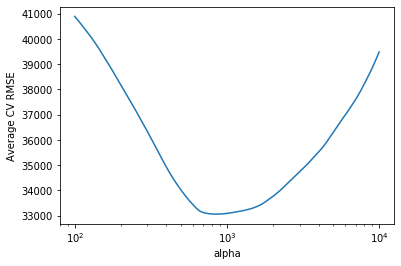

In [139]:
print("Best param:",best_lasso.best_params_)
print("Best MSE:",best_lasso.best_score_)
print("Best RMSE:",np.sqrt(-best_lasso.best_score_))

alpha = lasso_cv_scores.param_lasso__alpha.values
cv_score = lasso_cv_scores.mean_test_score.values

plt.yscale("linear")
plt.xscale("log")
plt.plot(alpha, np.sqrt(-cv_score))
plt.xlabel("alpha")
plt.ylabel("Average CV RMSE");

In [140]:
feat_names = list(train_df.columns)
lasso_coefs = sorted(list(zip(feat_names, best_lasso.best_estimator_.named_steps['lasso'].coef_)), 
               key=lambda x: x[1], 
               reverse=True)
print("{} features chosen by Lasso".format(np.sum(best_lasso.best_estimator_.named_steps['lasso'].coef_!=0)))
print([feat[0] for feat in lasso_coefs if feat[1]!=0])

81 features chosen by Lasso
['GrLivArea', 'OverallQual', 'Neighborhood_NridgHt', 'GarageCars', 'Neighborhood_NoRidge', 'BsmtExposure', 'Neighborhood_StoneBr', 'RoofMatl_WdShngl', 'KitchenQual', 'SaleType_New', 'ExterQual', 'MasVnrArea', 'OverallCond', 'BsmtQual', 'Neighborhood_Crawfor', 'MSSubClass_20', 'BsmtFinSF1', 'YearBuilt', 'BsmtFinType1', 'LotArea', 'LotConfig_CulDSac', 'Fireplaces', 'TotRmsAbvGrd', 'FullBath', 'HouseStyle_1Story', 'RoofMatl_CompShg', 'Condition1_Norm', 'Exterior1st_BrkFace', 'Neighborhood_Somerst', 'Exterior1st_CemntBd', 'BsmtFullBath', 'ScreenPorch', 'Neighborhood_BrkSide', 'WoodDeckSF', 'Exterior2nd_ImStucc', 'GarageType_None', 'HalfBath', 'HeatingQC', 'Foundation_Slab', 'SaleType_Con', 'Neighborhood_Veenker', 'Utilities', 'MoSold_7', 'MoSold_5', 'RoofMatl_Membran', 'Street_Pave', 'GarageFinish', 'Condition2_PosA', 'LandSlope', 'GarageType_BuiltIn', 'Foundation_PConc', 'YearRemodAdd', 'FireplaceQu', '3SsnPorch', 'Exterior1st_ImStucc', 'LowQualFinSF', 'SaleCon

**`LassoCV` gives approximately the same optimal $\alpha$ and chooses the same features**

In [147]:
lassocv_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')),
                         ('scale', StandardScaler()),
                         ('Lasso', LassoCV(max_iter=10000, normalize=False, cv=10, n_jobs=4))])
lassocv_pipe.fit(train_df.values, train_labels['SalePrice'].values)
lassocv_pipe.named_steps['Lasso'].alpha_

830.3910103604513

In [148]:
feat_names = list(train_df.columns)
lassocv_coefs = sorted(list(zip(feat_names, lassocv_pipe.named_steps['Lasso'].coef_)), 
                       key=lambda x: x[1], 
                       reverse=True)
print([feat[0] for feat in lassocv_coefs if feat[1]!=0])

['GrLivArea', 'OverallQual', 'Neighborhood_NridgHt', 'GarageCars', 'Neighborhood_NoRidge', 'BsmtExposure', 'Neighborhood_StoneBr', 'RoofMatl_WdShngl', 'KitchenQual', 'SaleType_New', 'ExterQual', 'MasVnrArea', 'OverallCond', 'BsmtQual', 'Neighborhood_Crawfor', 'MSSubClass_20', 'BsmtFinSF1', 'YearBuilt', 'BsmtFinType1', 'LotArea', 'LotConfig_CulDSac', 'Fireplaces', 'TotRmsAbvGrd', 'HouseStyle_1Story', 'FullBath', 'RoofMatl_CompShg', 'Condition1_Norm', 'Exterior1st_BrkFace', 'Neighborhood_Somerst', 'Exterior1st_CemntBd', 'BsmtFullBath', 'ScreenPorch', 'Neighborhood_BrkSide', 'WoodDeckSF', 'Exterior2nd_ImStucc', 'GarageType_None', 'HalfBath', 'HeatingQC', 'Foundation_Slab', 'SaleType_Con', 'Neighborhood_Veenker', 'Utilities', 'MoSold_7', 'MoSold_5', 'RoofMatl_Membran', 'Street_Pave', 'GarageFinish', 'Condition2_PosA', 'LandSlope', 'GarageType_BuiltIn', 'Foundation_PConc', 'YearRemodAdd', 'FireplaceQu', '3SsnPorch', 'Exterior1st_ImStucc', 'LowQualFinSF', 'SaleCondition_Family', 'Condition1_

In [149]:
set([feat[0] for feat in lasso_coefs if feat[1]!=0]) ^ set([feat[0] for feat in lassocv_coefs if feat[1]!=0])

set()

**`LassoLarsCV` gives approximately the same optimal $\alpha$ and chooses approximately the same features**

In [150]:
lassolarscv_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')),
                             ('scale', StandardScaler()),
                             ('LassoLars', LassoLarsCV(max_iter=10000, normalize=False, cv=10, n_jobs=4))])
lassolarscv_pipe.fit(train_df.values, train_labels['SalePrice'].values)
lassolarscv_pipe.named_steps['LassoLars'].alpha_

851.0084094948371

In [151]:
feat_names = list(train_df.columns)
lassolarscv_coefs = sorted(list(zip(feat_names, lassolarscv_pipe.named_steps['LassoLars'].coef_)), 
               key=lambda x: x[1], 
               reverse=True)
print([feat[0] for feat in lassolarscv_coefs if feat[1]!=0])

['GrLivArea', 'OverallQual', 'Neighborhood_NridgHt', 'GarageCars', 'Neighborhood_NoRidge', 'BsmtExposure', 'Neighborhood_StoneBr', 'RoofMatl_WdShngl', 'KitchenQual', 'SaleType_New', 'ExterQual', 'MasVnrArea', 'OverallCond', 'BsmtQual', 'MSSubClass_20', 'Neighborhood_Crawfor', 'BsmtFinSF1', 'YearBuilt', 'BsmtFinType1', 'LotArea', 'LotConfig_CulDSac', 'Fireplaces', 'FullBath', 'TotRmsAbvGrd', 'HouseStyle_1Story', 'RoofMatl_CompShg', 'Condition1_Norm', 'Exterior1st_BrkFace', 'Neighborhood_Somerst', 'Exterior1st_CemntBd', 'BsmtFullBath', 'ScreenPorch', 'Neighborhood_BrkSide', 'WoodDeckSF', 'Exterior2nd_ImStucc', 'GarageType_None', 'HeatingQC', 'HalfBath', 'Foundation_Slab', 'SaleType_Con', 'Neighborhood_Veenker', 'MoSold_7', 'Utilities', 'MoSold_5', 'RoofMatl_Membran', 'Street_Pave', 'GarageFinish', 'Condition2_PosA', 'LandSlope', 'GarageType_BuiltIn', 'Foundation_PConc', 'YearRemodAdd', 'FireplaceQu', 'Exterior1st_ImStucc', 'LowQualFinSF', 'SaleCondition_Family', 'LotConfig_FR3', 'Conditi

In [152]:
set([feat[0] for feat in lasso_coefs if feat[1]!=0]) ^ set([feat[0] for feat in lassolarscv_coefs if feat[1]!=0])

{'3SsnPorch'}

<br>
<br>

### Random Forest feature importance

With the help of the `RFECV` wrapper, we can iteratively prune features using the Random Forest `feature_importances_` attribute. Important features are those that when split on results in a large impurity decrease when averaged over all of the decision trees in the forest.

In [ ]:
train_df_copy = SimpleImputer(strategy='median').fit_transform(train_df)
rand_for = RandomForestRegressor(n_estimators=1000, n_jobs=4, max_features='sqrt')
selector = RFECV(rand_for, step=1, cv=5, n_jobs=2, scoring='neg_mean_squared_error', verbose=1)
selector = selector.fit(train_df_copy, train_labels['SalePrice'])

In [34]:
feat_names = np.array(train_df.columns)
print("{} features selected\n".format(selector.n_features_))
print(list(feat_names[selector.support_]),"\n")
print("Random Forest best RMSE: {}".format(np.sqrt(-selector.grid_scores_[37])))

38 features selected

['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'LotShape', 'ExterQual', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageFinish', 'HouseStyle_2Story', 'Neighborhood_NoRidge', 'Foundation_PConc', 'GarageType_Attchd', 'MSSubClass_60'] 

Random Forest best RMSE: 28782.81928525163


<br>
<br>

**Other feature selection techniques:**

- **Lasso Lars IC** - Perform the Lasso feature selection using an Information Criterion rather than directly using the evaluation metric (MSE). This should result in a different set of features 
    - Gives errors when tried
- **RFECV using `coef_`** - Recursive feature elimination using the magnitude of regression coefficient values as an indicator of feature importance (unimportant features are pruned first)
    - Relies on using the magnitude of coefficients in an additive model as an indicator of feature importance which is sensitive to the scale of features without normalization. We avoid normalization to retain model interpretability
- **PLS & PCR** - Selects linear combination of features that either retain a certain level of feature variance (PCA) or finds directions in the linear subspace that are most correlated with the response (PCR).
    - These methods are not used in an attempt to retain model interpretability as producing linear combinations of features results in a feature set that is not immediately interpretable

<br>
<br>

# Linear Regression with SFS chosen features

In [3]:
# Import data

train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
train_labels = train_df[['Id','SalePrice']]
test_id = pd.DataFrame(test_df['Id'])
all_data = train_df.append(test_df, sort=False)
all_data.drop(columns='SalePrice', inplace=True)

# Impute missing values (excluding LotFrontage)
from missing_data import MissingDataImputer
missing_imputer = MissingDataImputer()
all_data = missing_imputer.fit_transform(all_data)

# Transform categorical variables
from categorical_transformer import CatTransformer
cat_transf = CatTransformer()
all_data = cat_transf.fit_transform(all_data)

# Create LotFrontage imputer

train_df = all_data[all_data['Id'].isin(train_df['Id'])]
test_df = all_data[all_data['Id'].isin(test_df['Id'])]

train_df.drop(columns='Id', inplace=True)
test_df.drop(columns='Id', inplace=True)

# From above
sfs_feats = ['LotArea', 'OverallQual', 'OverallCond', 'GrLivArea', 'Fireplaces', 'GarageCars', 'WoodDeckSF', 'ScreenPorch', 'ExterQual', 'BsmtExposure', 'BsmtFinType1', 'KitchenQual', 'Functional', 'HouseStyle_2Story', 'LotConfig_CulDSac', 'Neighborhood_BrkSide', 'Neighborhood_Crawfor', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Condition1_Norm', 'RoofStyle_Hip', 'RoofMatl_WdShngl', 'Exterior1st_BrkFace', 'GarageType_None', 'SaleType_New', 'MSSubClass_20', 'MSSubClass_60']
train_df_sfs = train_df[sfs_feats]

In [3]:
lin_regr = sm.OLS(train_labels['SalePrice'].values,
                  sm.add_constant(train_df_sfs.values)).fit()
lin_regr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     313.0
Date:                Sun, 11 Aug 2019   Prob (F-statistic):               0.00
Time:                        20:17:14   Log-Likelihood:                -17088.
No. Observations:                1460   AIC:                         3.424e+04
Df Residuals:                    1430   BIC:                         3.439e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.381e+05   8067.166    -17.117      0.000   -1.54e+05   -1.22e+05
x1             0.3226      0.087      3.692      0.000       0.151       0.494
x2          1.058e+04   1044.922     10.126      0.000    8531.338    1.26e+04
x3          3671.2034    764.496      4.802      0.000    2171.550    5170.857
x4            51.5898      2.423     21.292      0.000      46.837      56.343
x5          4981.0443   1484.599      3.355      0.001    2068.818    7893.271
x6          1.368e+04   1707.346      8.013      0.000    1.03e+04     1.7e+04
x7            20.9654      6.830      3.070      0.002       7.568      34.363
x8            38.1636     14.421      2.646      0.008       9.876      66.451
x9          9585.5801   2310.693      4.148      0.000    5052.869    1.41e+04
x10         7163.8896    861.953      8.311      0.000    5473.062    8854.717
x11         2923.1347    415.522      7.035      0.000    2108.038    3738.232
x12         9093.1094   1835.662      4.954      0.000    5492.231    1.27e+04
x13        -4503.0778   1231.551     -3.656      0.000   -6918.918   -2087.237
x14        -1.173e+04   2981.562     -3.935      0.000   -1.76e+04   -5885.040
x15         1.293e+04   3277.989      3.944      0.000    6499.835    1.94e+04
x16         1.687e+04   4183.142      4.032      0.000    8659.423    2.51e+04
x17         2.888e+04   4572.087      6.316      0.000    1.99e+04    3.78e+04
x18         4.992e+04   5240.464      9.527      0.000    3.96e+04    6.02e+04
x19         5.131e+04   4188.374     12.251      0.000    4.31e+04    5.95e+04
x20         1.928e+04   3792.384      5.085      0.000    1.18e+04    2.67e+04
x21          5.64e+04   6381.542      8.838      0.000    4.39e+04    6.89e+04
x22         1.141e+04   2354.916      4.846      0.000    6793.162     1.6e+04
x23         6320.8659   2098.499      3.012      0.003    2204.400    1.04e+04
x24         8.153e+04   1.25e+04      6.512      0.000     5.7e+04    1.06e+05
x25         1.582e+04   4410.745      3.587      0.000    7171.305    2.45e+04
x26         1.692e+04   4361.220      3.879      0.000    8361.000    2.55e+04
x27         1.868e+04   3290.901      5.675      0.000    1.22e+04    2.51e+04
x28         1.905e+04   2040.827      9.333      0.000     1.5e+04    2.31e+04
x29          2.27e+04   3322.486      6.831      0.000    1.62e+04    2.92e+04
==============================================================================
Omnibus:                      545.760   Durbin-Watson:                   1.921
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            61549.588
Skew:                          -0.718   Prob(JB):                         0.00
Kurtosis:                      34.776   Cond. No.                     2.36e+05
==============================================================================

W

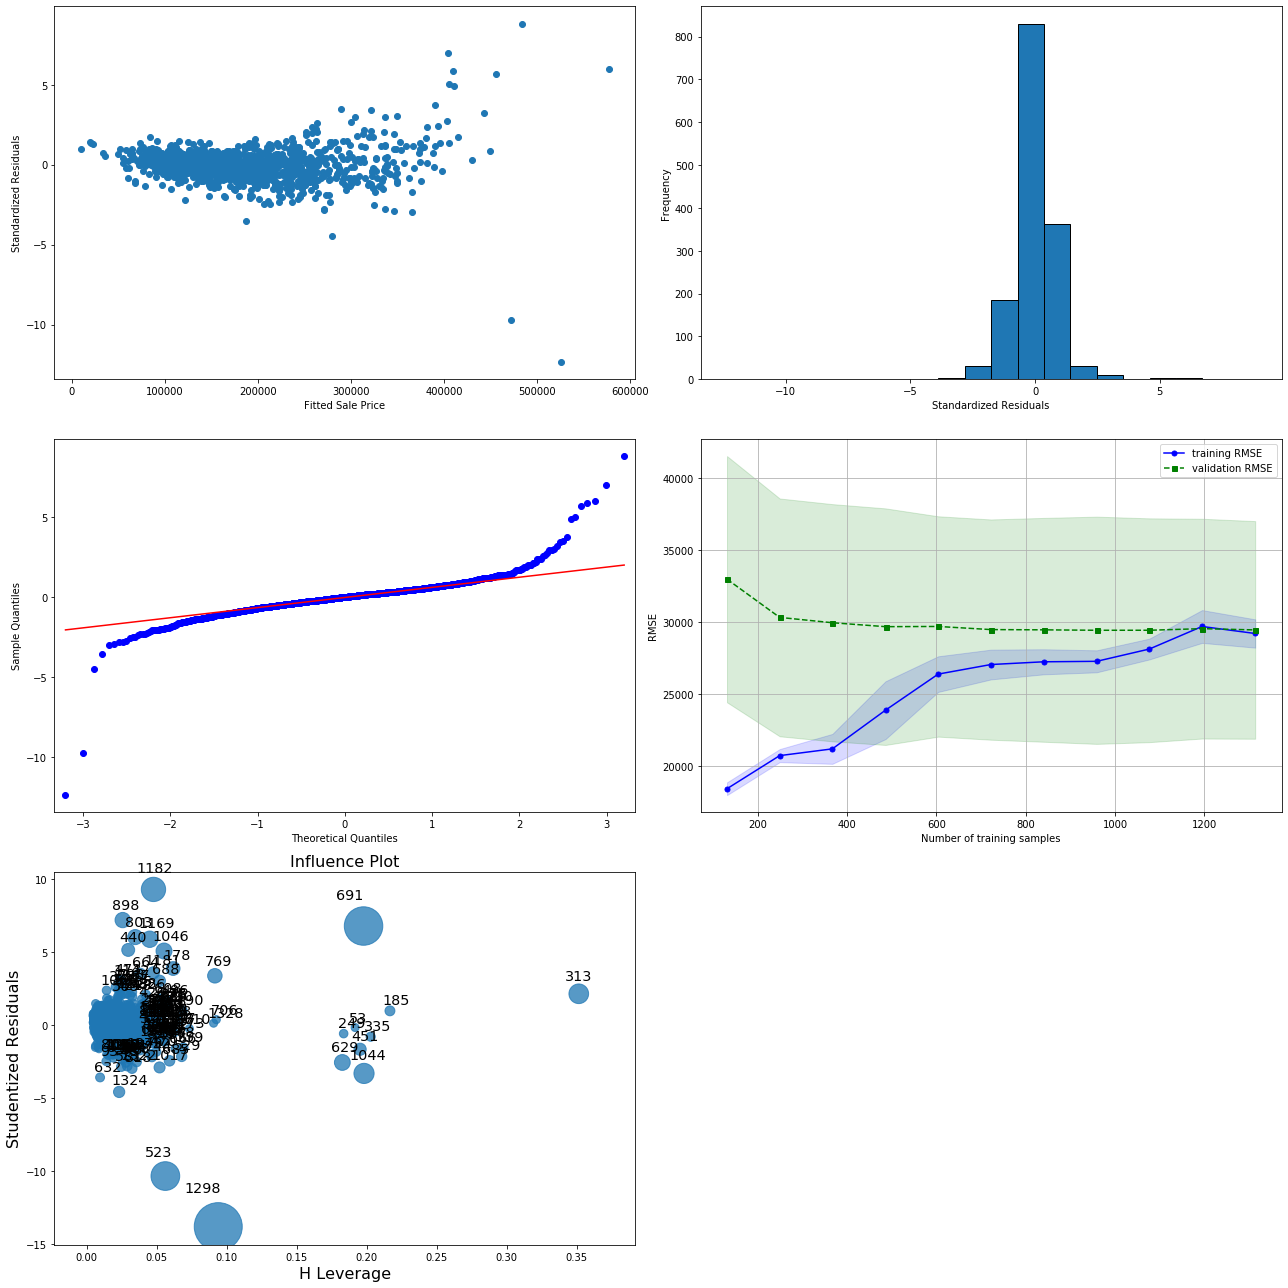

In [9]:
fig=plt.figure(figsize=(18,18))

ax1 = plt.subplot(321)
ax1.scatter(lin_regr.predict(), lin_regr.resid_pearson)
ax1.set_xlabel("Fitted Sale Price")
ax1.set_ylabel("Standardized Residuals")

ax2 = plt.subplot(322)
ax2.hist(lin_regr.resid_pearson, bins=20, edgecolor='k')
ax2.set_xlabel("Standardized Residuals")
ax2.set_ylabel("Frequency")

ax3 = plt.subplot(323)
fig = sm.qqplot(lin_regr.resid_pearson, line='q', ax=ax3)

ax4 = plt.subplot(324)
lin_regr_sk = LinearRegression()
lin_regr_sk.fit(train_df_sfs.values, train_labels['SalePrice'].values)

lc_params = compute_learning_curve(estimator=lin_regr_sk, 
                                   X=train_df_sfs.values, 
                                   y=train_labels['SalePrice'].values,
                                   cv=10)
plot_learning_curve(ax4, lc_params)

ax5 = plt.subplot(325)
fig = sm.graphics.influence_plot(lin_regr, ax=ax5, criterion="cooks")
plt.tight_layout()

**Observations**

- With the SFS reduced feature set, the $R^2$ value has reduced slightly to 0.864. However because of the non-linearity present, this result doesn't necessarily indicate a worse fit as a linear model is still inappropriate for the data.
- All the features have a p-value < 0.05 which means they are statistically significantly different from 0. They are all linearly associated with the response after accounting for all other features in the model
- From the normal plot and the histogram:
    - The residuals are still non-normal and heavy-tailed
- The residual plot shows a pattern which is indicative that a linear fit is inappropriate for this data
- From the learning curve:
    - Although it looks like there is more variation in the validation RMSE, this is actually due to the scale of the plot. The standard deviation for this curve at 1000 training samples is $\approx \pm 7500$ compared to $\approx \pm 15000$ using the whole feature set
    - The overfitting problem appears to have been solved as can be seen by the convergence of the training and validation RMSE curves
    - The learning curve may now be indicative of a slightly high bias problem which also can be seen by the non-linearity present in the residual plot. (The Random Forest used in feature selection was able to achieve ~28000 RMSE which is slightly lower than this model
- From the [influence plot](https://www.statsmodels.org/stable/examples/notebooks/generated/regression_plots.html) and the residual plot:
    - Point 1298, 523 and 1324 seems to not be following the upward trend in the residual plot and are also highly influential points as measured by their Cook's distance since they have high leverage and are outliers (have large absolute residuals)

<br>
<br>

## Remove influential points

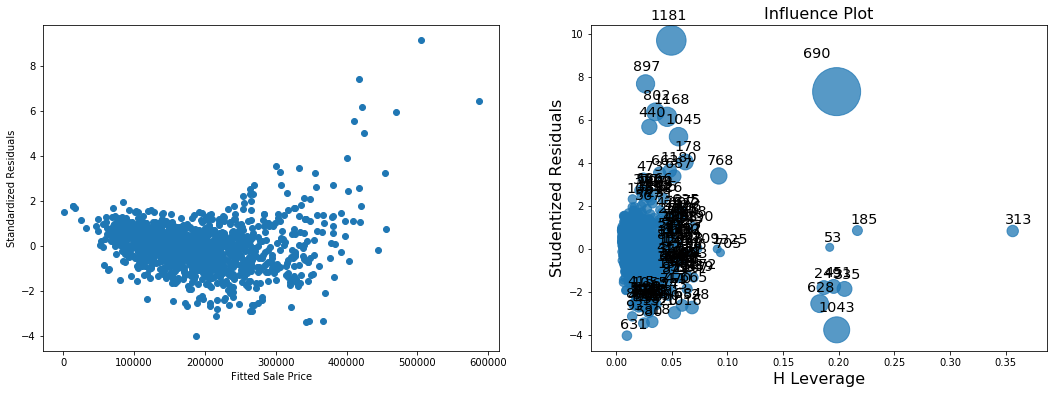

In [10]:
influential_points = [1298, 523, 1324]
lin_regr_drop = sm.OLS(train_labels['SalePrice'].drop(influential_points).values,
                  sm.add_constant(train_df_sfs.drop(influential_points).values)).fit()

fig=plt.figure(figsize=(18,6))
ax1 = plt.subplot(121)
ax1.scatter(lin_regr_drop.predict(), lin_regr_drop.resid_pearson)
ax1.set_xlabel("Fitted Sale Price")
ax1.set_ylabel("Standardized Residuals")

ax2 = plt.subplot(122)
fig = sm.graphics.influence_plot(lin_regr_drop, ax=ax2, criterion="cooks")

After removing the influential plots pulling the fit down, we have a clean upward trend that the linear fit from our model can't capture. It's time to tackle the non-linearity in the data!

<br>
<br>

## GLM and OLSR residual analysis

c:\users\wongt\desktop\advanced_regression_techniques_conda\venv\lib\site-packages\ipykernel_launcher.py:38: DeprecationWarning:

Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.



GLM RMSE: 21121.51792376516
Lin Regr RMSE: 197634.54855666807


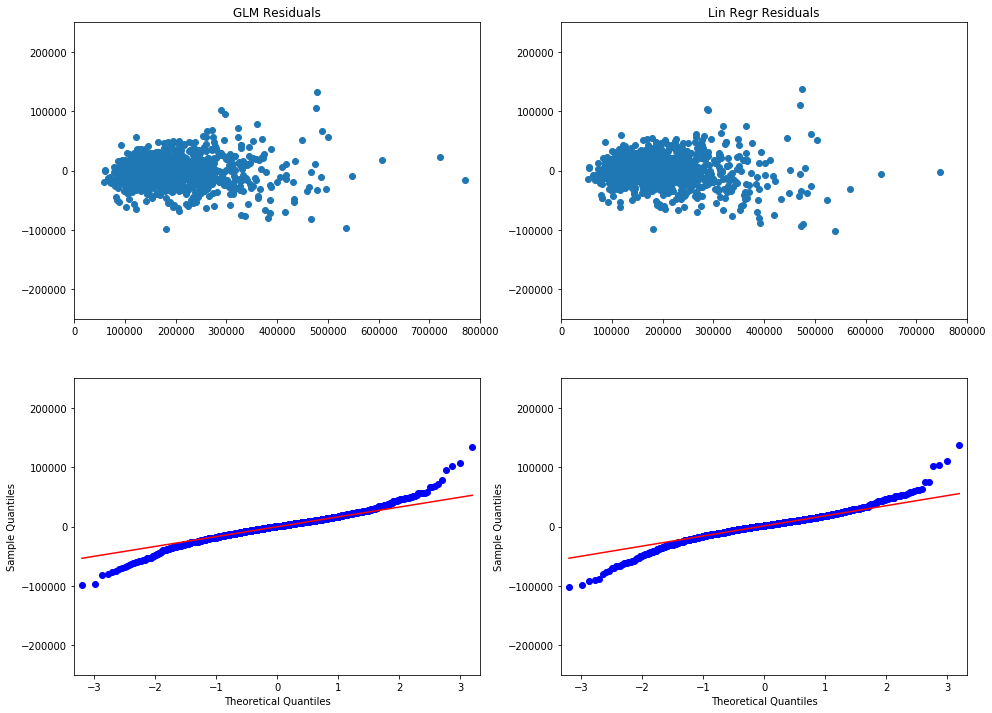

In [4]:
sfs_feats = ['LotArea', 'OverallQual', 'OverallCond', 'GrLivArea', 'Fireplaces', 'GarageCars', 'WoodDeckSF', 'ScreenPorch', 'ExterQual', 'BsmtExposure', 'BsmtFinType1', 'KitchenQual', 'Functional', 'HouseStyle_2Story', 'LotConfig_CulDSac', 'Neighborhood_BrkSide', 'Neighborhood_Crawfor', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Condition1_Norm', 'RoofStyle_Hip', 'RoofMatl_WdShngl', 'Exterior1st_BrkFace', 'GarageType_None', 'SaleType_New', 'MSSubClass_20', 'MSSubClass_60']
train_df_sfs = train_df[sfs_feats]

# Add feature engineering
#train_df_sfs['boxcox_LotArea'] = boxcox(train_df_sfs.LotArea.values)[0]
#train_df_sfs['boxcox_GrLivArea'] = boxcox(train_df_sfs.GrLivArea.values)[0]

#train_df_sfs['GrLivArea_HouseStyle_2Story'] = train_df_sfs['GrLivArea']*train_df_sfs['HouseStyle_2Story']
#train_df_sfs['GrLivArea_MSSubClass_20'] = train_df_sfs['GrLivArea']*train_df_sfs['MSSubClass_20']
#train_df_sfs['GrLivArea_MSSubClass_60'] = train_df_sfs['GrLivArea']*train_df_sfs['MSSubClass_60']
#train_df_sfs['GrLivArea_SaleType_New'] = train_df_sfs['GrLivArea']*train_df_sfs['SaleType_New']

#train_df_sfs['bcLotArea_HouseStyle_2Story'] = train_df_sfs['boxcox_LotArea']*train_df_sfs['HouseStyle_2Story']
#train_df_sfs['bcLotArea_MSSubClass_20'] = train_df_sfs['boxcox_LotArea']*train_df_sfs['MSSubClass_20']
#train_df_sfs['bcLotArea_MSSubClass_60'] = train_df_sfs['boxcox_LotArea']*train_df_sfs['MSSubClass_60']
#train_df_sfs['bcLotArea_SaleType_New'] = train_df_sfs['boxcox_LotArea']*train_df_sfs['SaleType_New']

# Scale
ohe_feats = train_df_sfs.select_dtypes(include='uint8').columns
num_ordinal_feats = train_df_sfs.select_dtypes(exclude='uint8').columns
train_df_sfs_scaled = pd.DataFrame(StandardScaler().fit_transform(train_df_sfs[num_ordinal_feats]), columns=num_ordinal_feats)
train_df_sfs = pd.concat([train_df_sfs_scaled, train_df_sfs[ohe_feats]], axis=1)
del(train_df_sfs_scaled)

# Drop influential points
influential_points = [1298, 523, 1324]
train_df_sfs.drop(influential_points, inplace=True)

# Add label to DataFrame
train_df_sfs['SalePrice'] = train_labels['SalePrice']

feat_names = list(train_df_sfs.columns)
feat_names.remove('SalePrice')
feat_names = '+'.join(feat_names)

glm_regr = smf.glm("SalePrice~{}".format(feat_names), 
                         data=train_df_sfs, 
                         family=sm.families.Gaussian(sm.families.links.log)
                  ).fit()

lin_regr = smf.ols("np.log(SalePrice)~{}".format(feat_names), 
                         data=train_df_sfs).fit()

fig=plt.figure(figsize=(16,12))

ax1 = plt.subplot(221)
ax1.scatter(glm_regr.predict(), train_df_sfs.SalePrice.values-glm_regr.predict())
ax1.set_title("GLM Residuals")
ax1.set_xlim(0,800000)
ax1.set_ylim(-250000,250000)

ax2 = plt.subplot(222)
ax2.scatter(np.exp(lin_regr.predict()), train_df_sfs.SalePrice.values-np.exp(lin_regr.predict()))
#ax2.scatter(lin_regr.predict(), lin_regr.resid_pearson)
ax2.set_title("Lin Regr Residuals")
ax2.set_xlim(0,800000)
ax2.set_ylim(-250000,250000)

ax3 = plt.subplot(223)
fig = sm.qqplot(train_df_sfs.SalePrice.values-glm_regr.predict(), line='q', ax=ax3)
ax3.set_ylim(-250000,250000)

#fig = sm.qqplot(glm_regr.resid_pearson, line='q', ax=ax3)

ax4 = plt.subplot(224)
fig = sm.qqplot(train_df_sfs.SalePrice.values-np.exp(lin_regr.predict()), line='q', ax=ax4)
ax4.set_ylim(-250000,250000)

#fig = sm.qqplot(lin_regr.resid_pearson, line='q', ax=ax4)

print("GLM RMSE: {}".format(np.sqrt(mean_squared_error(glm_regr.predict(), train_df_sfs.SalePrice))))
print("Lin Regr RMSE: {}".format(np.sqrt(mean_squared_error(lin_regr.predict(), train_df_sfs.SalePrice))))

lin_regr_with_fe = lin_regr

<br>
<br>

# Make a submission

**No feature engineering GLM**

In [99]:
sfs_feats = ['LotArea', 'OverallQual', 'OverallCond', 'GrLivArea', 'Fireplaces', 'GarageCars', 'WoodDeckSF', 'ScreenPorch', 'ExterQual', 'BsmtExposure', 'BsmtFinType1', 'KitchenQual', 'Functional', 'HouseStyle_2Story', 'LotConfig_CulDSac', 'Neighborhood_BrkSide', 'Neighborhood_Crawfor', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Condition1_Norm', 'RoofStyle_Hip', 'RoofMatl_WdShngl', 'Exterior1st_BrkFace', 'GarageType_None', 'SaleType_New', 'MSSubClass_20', 'MSSubClass_60']
train_df_sfs = train_df[sfs_feats]
test_df_sfs = test_df[sfs_feats]


# Scale
scaler = StandardScaler()
ohe_feats = train_df_sfs.select_dtypes(include='uint8').columns
num_ordinal_feats = train_df_sfs.select_dtypes(exclude='uint8').columns
train_df_sfs_scaled = pd.DataFrame(scaler.fit_transform(train_df_sfs[num_ordinal_feats]), columns=num_ordinal_feats)
test_df_sfs_scaled = pd.DataFrame(scaler.transform(test_df_sfs[num_ordinal_feats]), columns=num_ordinal_feats)
train_df_sfs = pd.concat([train_df_sfs_scaled, train_df_sfs[ohe_feats]], axis=1)
test_df_sfs = pd.concat([test_df_sfs_scaled, test_df_sfs[ohe_feats]], axis=1)
del(train_df_sfs_scaled)
del(test_df_sfs_scaled)

# Drop influential points
influential_points = [1298, 523, 1324]
train_df_sfs.drop(influential_points, inplace=True)

# Add label to DataFrame
train_df_sfs['SalePrice'] = train_labels['SalePrice']

feat_names = list(train_df_sfs.columns)
feat_names.remove('SalePrice')
feat_names = '+'.join(feat_names)

glm_regr = smf.glm("SalePrice~{}".format(feat_names), 
                         data=train_df_sfs, 
                         family=sm.families.Gaussian(sm.families.links.log)
                  ).fit()


print("GLM RMSE: {}".format(np.sqrt(mean_squared_error(glm_regr.predict(), train_df_sfs.SalePrice))))

GLM RMSE: 21121.51792376516


c:\users\wongt\desktop\advanced_regression_techniques_conda\venv\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning:

Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.



In [94]:
today = datetime.datetime.today()

submission_df = test_id.copy()
submission_df['SalePrice'] = glm_regr.predict(test_df_sfs)
submission_df.to_csv("submissions/{}{}{}_attempt1_GLMnoFE.csv".format(today.year,today.month,today.day), index=False)

<br>
<br>

**No feature engineering OSLR with log response**

In [3]:
sfs_feats = ['LotArea', 'OverallQual', 'OverallCond', 'GrLivArea', 'Fireplaces', 'GarageCars', 'WoodDeckSF', 'ScreenPorch', 'ExterQual', 'BsmtExposure', 'BsmtFinType1', 'KitchenQual', 'Functional', 'HouseStyle_2Story', 'LotConfig_CulDSac', 'Neighborhood_BrkSide', 'Neighborhood_Crawfor', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Condition1_Norm', 'RoofStyle_Hip', 'RoofMatl_WdShngl', 'Exterior1st_BrkFace', 'GarageType_None', 'SaleType_New', 'MSSubClass_20', 'MSSubClass_60']
train_df_sfs = train_df[sfs_feats]
test_df_sfs = test_df[sfs_feats]


# Scale
scaler = StandardScaler()
ohe_feats = train_df_sfs.select_dtypes(include='uint8').columns
num_ordinal_feats = train_df_sfs.select_dtypes(exclude='uint8').columns
train_df_sfs_scaled = pd.DataFrame(scaler.fit_transform(train_df_sfs[num_ordinal_feats]), columns=num_ordinal_feats)
train_df_sfs = pd.concat([train_df_sfs_scaled, train_df_sfs[ohe_feats]], axis=1)
test_df_sfs_scaled = pd.DataFrame(scaler.transform(test_df_sfs[num_ordinal_feats]), columns=num_ordinal_feats)
test_df_sfs = pd.concat([test_df_sfs_scaled, test_df_sfs[ohe_feats]], axis=1)

del(train_df_sfs_scaled)
del(test_df_sfs_scaled)

# Drop influential points
influential_points = [1298, 523, 1324]
train_df_sfs.drop(influential_points, inplace=True)

# Add label to DataFrame
train_df_sfs['SalePrice'] = train_labels['SalePrice']

feat_names = list(train_df_sfs.columns)
feat_names.remove('SalePrice')
feat_names = '+'.join(feat_names)

lin_regr = smf.ols("np.log(SalePrice)~{}".format(feat_names), 
                         data=train_df_sfs, 
                         #family=sm.families.Gaussian(sm.families.links.log)
                  ).fit()


print("Lin Regr RMSE: {}".format(np.sqrt(mean_squared_error(np.exp(lin_regr.predict()), train_df_sfs.SalePrice))))

Lin Regr RMSE: 21687.26845693485


In [4]:
today = datetime.datetime.today()

submission_df = test_id.copy()
submission_df['SalePrice'] = np.exp(lin_regr.predict(test_df_sfs))
submission_df.to_csv("submissions/{}{}{}_attempt3_OLSRnoFELog.csv".format(today.year,today.month,today.day), index=False)

<br>
<br>

**Observations**

- Gaussian GLM with Log link scored 0.14698 whilst OLSR scored 0.24369. OLSR fit to the log response scored 0.14319.
- OLSR fit to the log reponse scored the best.
- From the residual plots:
    - Log transforming the response appears to have taken care of the non-linear pattern appearing in the residuals
    - The residuals are still heavy tailed and are not normal but test performance has improved a lot compared to non-transformed response performance
- Should try feature selection again but using the log transformed response instead

<br>
<br>

# Feature selection with Lasso using Log response

In [2]:
# Import data

train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
train_labels = train_df[['Id','SalePrice']]
test_id = pd.DataFrame(test_df['Id'])
all_data = train_df.append(test_df, sort=False)
all_data.drop(columns='SalePrice', inplace=True)

# Impute missing values (excluding LotFrontage)
from missing_data import MissingDataImputer
missing_imputer = MissingDataImputer()
all_data = missing_imputer.fit_transform(all_data)

# Transform categorical variables
from categorical_transformer import CatTransformer
cat_transf = CatTransformer()
all_data = cat_transf.fit_transform(all_data)

# Create LotFrontage imputer
lotfrontage_imputer = MissingDataImputer(impute_lotfrontage=True)

train_df = all_data[all_data['Id'].isin(train_df['Id'])]
test_df = all_data[all_data['Id'].isin(test_df['Id'])]

train_df.drop(columns='Id', inplace=True)
test_df.drop(columns='Id', inplace=True)

In [13]:
lasso_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')),
                       ('scale', StandardScaler()),
                       ('lasso', Lasso(max_iter=10000))])
lasso_gs = GridSearchCV(lasso_pipe,
                        {'lasso__alpha':np.logspace(-3.5,-1.5, 101)},
                        'neg_mean_squared_error',
                        n_jobs=4,
                        iid=False,
                        cv=10,
                       )
best_lasso = lasso_gs.fit(train_df.values, np.log(train_labels['SalePrice'].values))
lasso_cv_scores = pd.DataFrame(best_lasso.cv_results_)

Best param: {'lasso__alpha': 0.003981071705534973}
Best MSE: -0.020880699674591607
Best RMSE: 0.14450155595906783


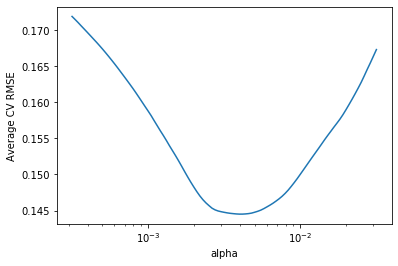

In [14]:
print("Best param:",best_lasso.best_params_)
print("Best MSE:",best_lasso.best_score_)
print("Best RMSE:",np.sqrt(-best_lasso.best_score_))

alpha = lasso_cv_scores.param_lasso__alpha.values
cv_score = lasso_cv_scores.mean_test_score.values

plt.yscale("linear")
plt.xscale("log")
plt.plot(alpha, np.sqrt(-cv_score))
plt.xlabel("alpha")
plt.ylabel("Average CV RMSE");

In [15]:
feat_names = list(train_df.columns)
lasso_coefs = sorted(list(zip(feat_names, best_lasso.best_estimator_.named_steps['lasso'].coef_)), 
               key=lambda x: x[1], 
               reverse=True)
print("{} features chosen by Lasso".format(np.sum(best_lasso.best_estimator_.named_steps['lasso'].coef_!=0)))
print([feat[0] for feat in lasso_coefs if feat[1]!=0])

85 features chosen by Lasso
['GrLivArea', 'OverallQual', 'GarageCars', 'OverallCond', 'YearBuilt', 'Neighborhood_NridgHt', 'BsmtFinType1', 'Neighborhood_Crawfor', 'SaleType_New', 'BsmtFullBath', 'FullBath', 'BsmtQual', 'MSSubClass_20', 'FireplaceQu', 'CentralAir_Y', 'BsmtExposure', 'MSZoning_RL', 'KitchenQual', 'Neighborhood_StoneBr', '1stFlrSF', 'Neighborhood_Somerst', 'SaleCondition_Normal', 'Condition1_Norm', 'LotArea', 'HeatingQC', 'Neighborhood_NoRidge', 'ScreenPorch', 'HalfBath', 'TotRmsAbvGrd', 'YearRemodAdd', 'WoodDeckSF', 'LotConfig_CulDSac', 'Exterior1st_BrkFace', 'Foundation_PConc', 'Neighborhood_ClearCr', 'GarageArea', 'MSZoning_FV', 'ExterQual', 'Fireplaces', 'Heating_GasW', 'RoofMatl_WdShngl', 'GarageFinish', 'PavedDrive', 'GarageType_Attchd', 'Neighborhood_Veenker', 'GarageQual', 'Neighborhood_BrkSide', 'Street_Pave', 'Utilities', 'RoofMatl_CompShg', 'MasVnrArea', 'MoSold_5', 'TotalBsmtSF', 'BsmtFinSF1', '3SsnPorch', 'RoofMatl_Membran', 'OpenPorchSF', 'GarageType_Basment

**`LassoCV` gives approximately the same optimal $\alpha$ and chooses the same features**

In [16]:
lassocv_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')),
                         ('scale', StandardScaler()),
                         ('Lasso', LassoCV(max_iter=10000, normalize=False, cv=10, n_jobs=4))])
lassocv_pipe.fit(train_df.values, np.log(train_labels['SalePrice'].values))
lassocv_pipe.named_steps['Lasso'].alpha_

0.0040229519239743695

<br>
<br>

## Build model

In order to improve the score, the following were tried iteratively
- Remove highly influential points
- Remove features with high VIF (>10) that are not as correlated with the response
- Check for useful interaction features that can be produced by:
    - Identifying important features by fitting model to scaled (standardized) data and checking the magnitude of the coefficients
    - Combine important categorical and numerical features and add them to the model

25397.403411399075


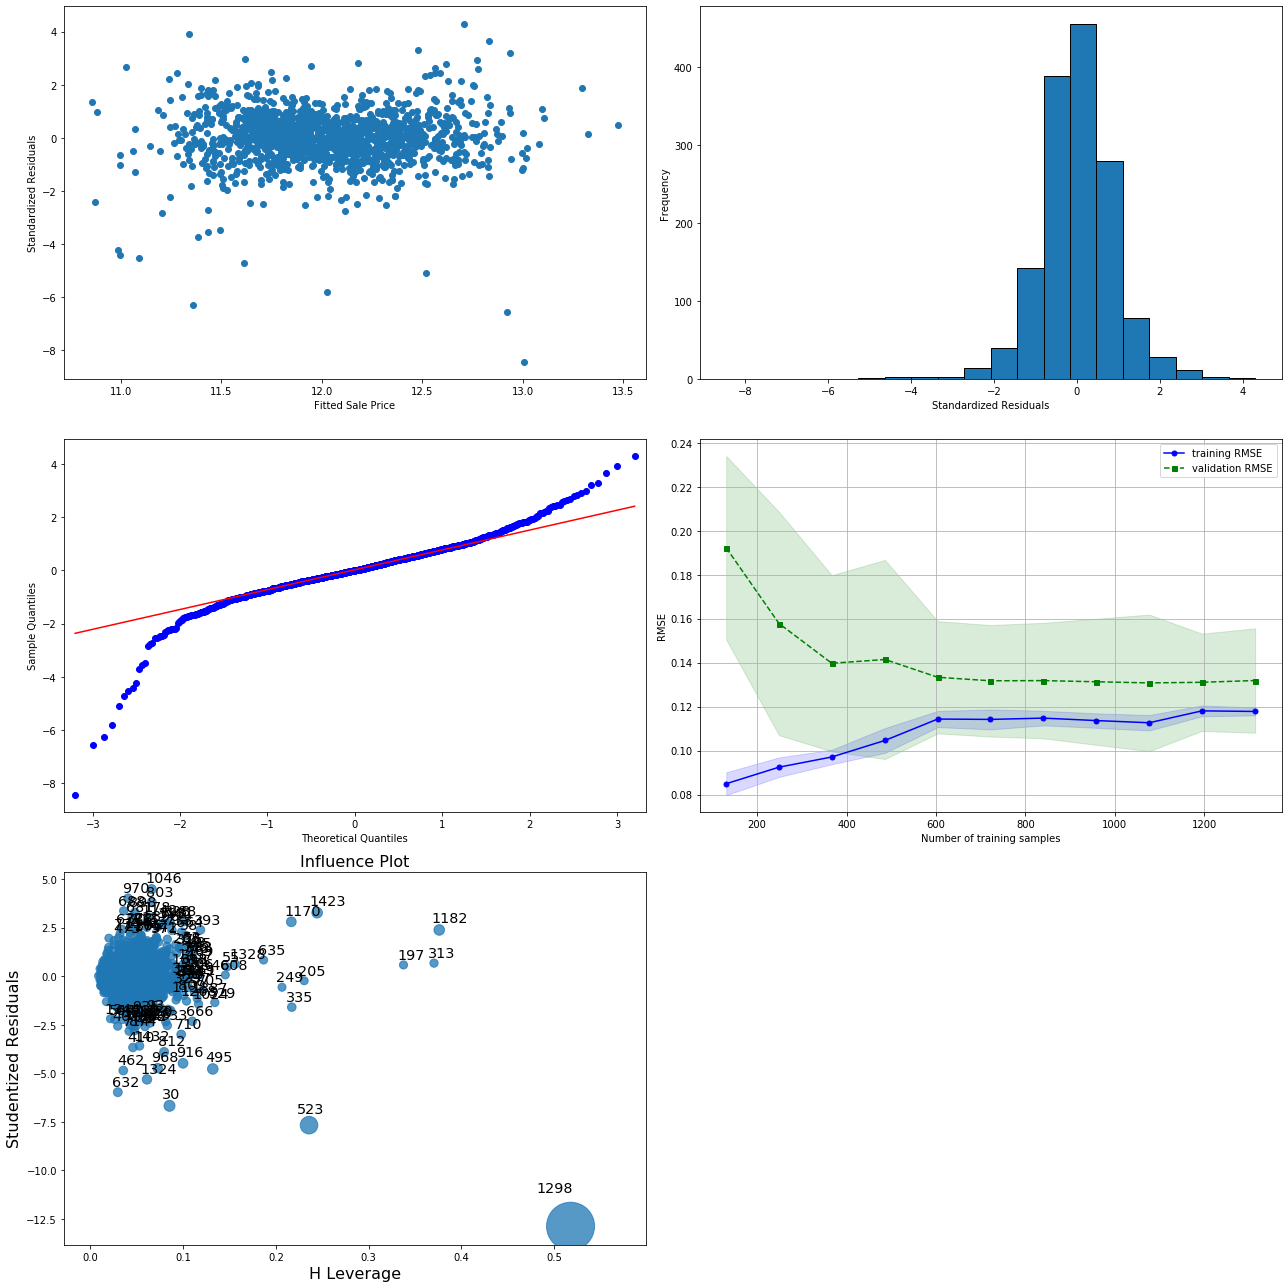

In [16]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
train_labels = train_df[['Id','SalePrice']]
test_id = pd.DataFrame(test_df['Id'])
all_data = train_df.append(test_df, sort=False)
all_data.drop(columns='SalePrice', inplace=True)

# Impute missing values (excluding LotFrontage)
from missing_data import MissingDataImputer
missing_imputer = MissingDataImputer()
all_data = missing_imputer.fit_transform(all_data)

# Transform categorical variables
from categorical_transformer import CatTransformer
cat_transf = CatTransformer()
all_data = cat_transf.fit_transform(all_data)

train_df = all_data[all_data['Id'].isin(train_df['Id'])]
test_df = all_data[all_data['Id'].isin(test_df['Id'])]

train_df.drop(columns='Id', inplace=True)
test_df.drop(columns='Id', inplace=True)

# No dropped features
#lasso_feats=['GrLivArea', 'OverallQual', 'GarageCars', 'OverallCond', 'YearBuilt', 'Neighborhood_NridgHt', 'BsmtFinType1', 'Neighborhood_Crawfor', 'SaleType_New', 'BsmtFullBath', 'FullBath', 'BsmtQual', 'MSSubClass_20', 'FireplaceQu', 'CentralAir_Y', 'BsmtExposure', 'MSZoning_RL', 'KitchenQual', 'Neighborhood_StoneBr', '1stFlrSF', 'Neighborhood_Somerst', 'SaleCondition_Normal', 'Condition1_Norm', 'LotArea', 'HeatingQC', 'Neighborhood_NoRidge', 'ScreenPorch', 'HalfBath', 'TotRmsAbvGrd', 'YearRemodAdd', 'WoodDeckSF', 'LotConfig_CulDSac', 'Exterior1st_BrkFace', 'Foundation_PConc', 'Neighborhood_ClearCr', 'GarageArea', 'MSZoning_FV', 'ExterQual', 'Fireplaces', 'Heating_GasW', 'RoofMatl_WdShngl', 'GarageFinish', 'PavedDrive', 'GarageType_Attchd', 'Neighborhood_Veenker', 'GarageQual', 'Neighborhood_BrkSide', 'Street_Pave', 'Utilities', 'RoofMatl_CompShg', 'MasVnrArea', 'MoSold_5', 'TotalBsmtSF', 'BsmtFinSF1', '3SsnPorch', 'RoofMatl_Membran', 'OpenPorchSF', 'GarageType_Basment', 'HouseStyle_2.5Fin', 'YrSold_2009', 'GarageType_CarPort', 'MSSubClass_180', 'Condition1_RRAe', 'RoofStyle_Gable', 'MoSold_10', 'Exterior2nd_Wd Shng', 'Fence_GdWo', 'Exterior1st_Wd Sdng', 'Condition1_Feedr', 'Exterior2nd_Stucco', 'Exterior1st_HdBoard', 'Heating_Grav', 'KitchenAbvGr', 'Exterior1st_BrkComm', 'BldgType_TwnhsE', 'PoolQC', 'MSSubClass_30', 'Neighborhood_OldTown', 'BldgType_Twnhs', 'Neighborhood_Edwards', 'Neighborhood_MeadowV', 'Neighborhood_IDOTRR', 'Functional', 'MSSubClass_160', 'Condition2_PosN']
# drop features
lasso_feats = ['GrLivArea', 'OverallQual', 'GarageCars', 'OverallCond', 'YearBuilt', 'Neighborhood_NridgHt', 'BsmtFinType1', 'Neighborhood_Crawfor', 'SaleType_New', 'BsmtFullBath', 'FullBath', 'BsmtQual', 'MSSubClass_20', 'FireplaceQu', 'CentralAir_Y', 'BsmtExposure', 'MSZoning_RL', 'KitchenQual', '1stFlrSF', 'Neighborhood_Somerst', 'SaleCondition_Normal', 'Condition1_Norm', 'LotArea', 'HeatingQC', 'Neighborhood_NoRidge', 'ScreenPorch', 'HalfBath', 'YearRemodAdd', 'WoodDeckSF', 'LotConfig_CulDSac', 'Exterior1st_BrkFace', 'Foundation_PConc', 'GarageArea', 'MSZoning_FV', 'ExterQual', 'Fireplaces', 'GarageFinish', 'PavedDrive', 'GarageType_Attchd', 'GarageQual', 'Neighborhood_BrkSide', 'MasVnrArea', 'MoSold_5', 'TotalBsmtSF', 'BsmtFinSF1', '3SsnPorch', 'OpenPorchSF', 'YrSold_2009', 'RoofStyle_Gable', 'MoSold_10', 'Exterior2nd_Wd Shng', 'Fence_GdWo', 'Exterior1st_Wd Sdng', 'Condition1_Feedr', 'Exterior1st_HdBoard', 'KitchenAbvGr', 'BldgType_TwnhsE', 'PoolQC', 'MSSubClass_30', 'Neighborhood_OldTown', 'BldgType_Twnhs', 'Neighborhood_Edwards', 'Neighborhood_IDOTRR', 'Functional', 'MSSubClass_160']

train_df_lasso = train_df[lasso_feats].copy()
test_df_lasso = test_df[lasso_feats].copy()
train_label = train_labels.copy()

# Feature engineering
train_df_lasso['GrLivArea_SaleType_New'] = train_df_lasso['GrLivArea'] * train_df_lasso['SaleType_New']
test_df_lasso['GrLivArea_SaleType_New'] = test_df_lasso['GrLivArea'] * test_df_lasso['SaleType_New']
train_df_lasso['OverallQual_SaleCondition_Normal'] = train_df_lasso['GrLivArea'] * train_df_lasso['SaleCondition_Normal']
test_df_lasso['OverallQual_SaleCondition_Normal'] = test_df_lasso['GrLivArea'] * test_df_lasso['SaleCondition_Normal']

# Drop influential points
#influential_points = [1298, 825, 523] # 0.12282
#train_df_lasso.drop(influential_points, inplace=True)
#train_label.drop(influential_points, inplace=True)

# Scale
#scaler = StandardScaler()
#cat_feats = list(train_df_lasso.select_dtypes(include='uint8').columns)
#num_feats = list(train_df_lasso.select_dtypes(exclude='uint8').columns)
#train_df_lasso_scaled = scaler.fit_transform(train_df_lasso[num_feats])
#test_df_lasso_scaled = scaler.transform(test_df_lasso[num_feats])
#train_df_lasso = np.column_stack((train_df_lasso_scaled, train_df_lasso[cat_feats].values))
#test_df_lasso = np.column_stack((test_df_lasso_scaled, test_df_lasso[cat_feats].values))
#train_df_lasso = pd.DataFrame(train_df_lasso, columns = num_feats+cat_feats)
#test_df_lasso = pd.DataFrame(test_df_lasso, columns = num_feats+cat_feats)
#del(train_df_lasso_scaled)
#del(test_df_lasso_scaled)

X_train = train_df_lasso.values
X_test = test_df_lasso.values
y_train = np.log(train_label['SalePrice'].values)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

lin_regr = sm.OLS(y_train, X_train).fit()
lin_regr_sk = LinearRegression()
lin_regr_sk.fit(train_df_lasso.values, y_train)

print(np.sqrt(mean_squared_error(train_label['SalePrice'].values, np.exp(lin_regr.predict()))))

fig=plt.figure(figsize=(18,18))

ax1 = plt.subplot(321)
ax1.scatter(lin_regr.predict(), lin_regr.resid_pearson)
ax1.set_xlabel("Fitted Sale Price")
ax1.set_ylabel("Standardized Residuals")

ax2 = plt.subplot(322)
ax2.hist(lin_regr.resid_pearson, bins=20, edgecolor='k')
ax2.set_xlabel("Standardized Residuals")
ax2.set_ylabel("Frequency")

ax3 = plt.subplot(323)
fig = sm.qqplot(lin_regr.resid_pearson, line='q', ax=ax3)

ax4 = plt.subplot(324)
lc_params = compute_learning_curve(estimator=lin_regr_sk, 
                                   X=train_df_lasso.values, 
                                   y=y_train,
                                   cv=10)
plot_learning_curve(ax4, lc_params)

ax5 = plt.subplot(325)
fig = sm.graphics.influence_plot(lin_regr, ax=ax5, criterion="cooks")
plt.tight_layout()

<br>
<br>

**Feature importance using standardized coefficients**

In [9]:
coef_dict = {}
coef_dict['intercept'] = lin_regr.params[0]

for idx, coef in enumerate(lin_regr.params[1:]):
    coef_dict[list(train_df_lasso.columns)[idx]] = coef
coef_series = pd.Series(coef_dict)
del(coef_dict)

<br>
<br>

**Check for useful interactions**

In [ ]:
train_df_lasso_copy = train_df_lasso.copy()
train_df_lasso_copy['SalePrice'] = np.log(train_label['SalePrice'].values)
sns.pairplot(train_df_lasso_copy[num_feats[:16]+['MSZoning_FV','SalePrice']], 
             vars=num_feats[:16]+['SalePrice'],
             hue='MSZoning_FV'
            )
sns.pairplot(train_df_lasso_copy[num_feats[16:]+['MSZoning_FV','SalePrice']], 
             vars=num_feats[16:]+['SalePrice'],
             hue='MSZoning_FV'
            )

<br>
<br>

**Check VIF**

In [8]:
vif_dict = {}
for idx, feat in enumerate(train_df_lasso.columns):
    vif_dict[feat] = variance_inflation_factor(sm.add_constant(train_df_lasso.values, has_constant='add'), idx+1);
vif_series = pd.Series(vif_dict)
del(vif_dict)
vif_series.sort_values(ascending=False)

YearBuilt      7.636981
GrLivArea      7.440883
1stFlrSF       7.114879
GarageCars     6.366938
GarageArea     5.868040
                 ...   
MoSold_10      1.082952
MoSold_5       1.073650
Fence_GdWo     1.066204
3SsnPorch      1.050312
YrSold_2009    1.043239
Length: 65, dtype: float64

<br>
<br>

**Make submission**

In [3]:
today = datetime.datetime.today()

submission_df = test_id.copy()
submission_df['SalePrice'] = np.exp(lin_regr.predict(X_test))
submission_df.to_csv("submissions/{}{}{}_attempt6_OLSRLassofeatsdropped4FE.csv".format(today.year,today.month,today.day), index=False)

0.12899 **With all features**

0.12412 **Dropped first set of features**

0.12405 **Dropped second set of features**

0.12282 **Dropped second set of features, dropped different outliers**

0.12257 **Add GrLivArea*SaleType_New, Drop [1298, 825, 523]**

0.12302 **Drop more features**

0.12257 **Drop [1298, 523, 30, 632, 825], add OverallQual*SaleCondition_New**

<br>
<br>

# Feature selection with SFS using Log response

- The floating variant of SFS is computationally inefficient (and throws an error) so I opted for a greedy forward search to save time

In [2]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
train_labels = train_df[['Id','SalePrice']]
test_id = pd.DataFrame(test_df['Id'])
all_data = train_df.append(test_df, sort=False)
all_data.drop(columns='SalePrice', inplace=True)

# Impute missing values (excluding LotFrontage)
from missing_data import MissingDataImputer
missing_imputer = MissingDataImputer()
all_data = missing_imputer.fit_transform(all_data)

# Transform categorical variables
from categorical_transformer import CatTransformer
cat_transf = CatTransformer()
all_data = cat_transf.fit_transform(all_data)

train_df = all_data[all_data['Id'].isin(train_df['Id'])]
test_df = all_data[all_data['Id'].isin(test_df['Id'])]

train_df.drop(columns='Id', inplace=True)
test_df.drop(columns='Id', inplace=True)

influential_points = [1298, 523, 30, 632]
train_df.drop(influential_points, inplace=True)
train_labels.drop(influential_points, inplace=True)

# Scale
scaler = StandardScaler()
cat_feats = list(train_df.select_dtypes(include='uint8').columns)
num_feats = list(train_df.select_dtypes(exclude='uint8').columns)
train_df_scaled = scaler.fit_transform(train_df[num_feats])
train_df = np.column_stack((train_df_scaled, train_df[cat_feats].values))
train_df = pd.DataFrame(train_df, columns = num_feats+cat_feats)
del(train_df_scaled)

In [ ]:
feat_names = list(train_df.columns)
sfs_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')),
                     ('lin_regr', LinearRegression())])

sfs = SFS(sfs_pipe, 
          k_features='parsimonious', 
          forward=True, 
          floating=False, 
          verbose=1,
          scoring='neg_mean_squared_error',
          cv=10,
          n_jobs=5
         )

sfs = sfs.fit(train_df.values, np.log(train_labels['SalePrice'].values), custom_feature_names=feat_names)

In [4]:
print("Parsimonious SFS:\n")
print("{} features chosen by SFS\n".format(len(sfs.k_feature_names_)))
print("Selected features: {}\n".format(sfs.k_feature_names_))
print("Best score: {}".format(np.sqrt(-sfs.k_score_)))

Parsimonious SFS:

49 features chosen by SFS

Selected features: ('LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'TotalBsmtSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'KitchenAbvGr', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'ScreenPorch', 'Alley', 'BsmtExposure', 'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageQual', 'HouseStyle_2.5Fin', 'Street_Pave', 'MSZoning_RM', 'LotConfig_CulDSac', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_Crawfor', 'Neighborhood_MeadowV', 'Neighborhood_NridgHt', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Condition1_Norm', 'Exterior1st_BrkFace', 'Foundation_PConc', 'Foundation_Wood', 'Heating_Wall', 'CentralAir_Y', 'SaleType_New', 'SaleCondition_AdjLand', 'SaleCondition_Normal', 'MSSubClass_160', 'MSSubClass_20', 'MSSubClass_30', 'MoSold_5')

Best score: 0.10430283505677086


In [8]:
sfs_scores = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
sfs_scores.to_csv("data/sfs_df_log_response_non_floating.csv", index=False)  # Save the SFS results
sfs_scores['RMSE'] = (-sfs_scores['avg_score'])**0.5

In [9]:
sfs_scores.sort_values('avg_score', ascending=False).head()

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,RMSE
78,"(0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 14, 15, 17, 18...","[-0.010032162999424363, -0.008882503536288259,...",-0.0106628,"(LotFrontage, LotArea, OverallQual, OverallCon...",0.00149485,0.00201269,0.000670897,0.103261
80,"(0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 14, 15, 17, 18...","[-0.010205674437046881, -0.00873888535516394, ...",-0.0106812,"(LotFrontage, LotArea, OverallQual, OverallCon...",0.00151634,0.00204162,0.00068054,0.10335
72,"(0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 14, 15, 17, 18...","[-0.009964993384053121, -0.008825820568827913,...",-0.010691,"(LotFrontage, LotArea, OverallQual, OverallCon...",0.00172951,0.00232863,0.000776211,0.103397
67,"(0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 14, 15, 17, 18...","[-0.010126939092546338, -0.009001822087242043,...",-0.0106916,"(LotFrontage, LotArea, OverallQual, OverallCon...",0.00169934,0.00228802,0.000762673,0.1034
75,"(0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 14, 15, 17, 18...","[-0.010099716290393527, -0.008586819777907559,...",-0.0106945,"(LotFrontage, LotArea, OverallQual, OverallCon...",0.00165299,0.0022256,0.000741868,0.103414


Chosen parsimonious model

In [7]:
sfs_scores[sfs_scores['avg_score']==sfs.k_score_]

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,RMSE
49,"(0, 1, 2, 3, 4, 5, 7, 10, 14, 15, 17, 18, 20, ...","[-0.010429587853682854, -0.008918473067264414,...",-0.0108791,"(LotFrontage, LotArea, OverallQual, OverallCon...",0.00168611,0.00227021,0.000756736,0.104303


___

**Parsimonious score features**

In [21]:
print("Log RMSE: {}".format(np.sqrt(-sfs.k_score_)))
print(sfs.k_feature_names_)

Log RMSE: 0.10430283505677086
('LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'TotalBsmtSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'KitchenAbvGr', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'ScreenPorch', 'Alley', 'BsmtExposure', 'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageQual', 'HouseStyle_2.5Fin', 'Street_Pave', 'MSZoning_RM', 'LotConfig_CulDSac', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_Crawfor', 'Neighborhood_MeadowV', 'Neighborhood_NridgHt', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Condition1_Norm', 'Exterior1st_BrkFace', 'Foundation_PConc', 'Foundation_Wood', 'Heating_Wall', 'CentralAir_Y', 'SaleType_New', 'SaleCondition_AdjLand', 'SaleCondition_Normal', 'MSSubClass_160', 'MSSubClass_20', 'MSSubClass_30', 'MoSold_5')


**Best score features**

In [22]:
print("Log RMSE: {}".format(np.sqrt(-sfs_scores.sort_values('avg_score', ascending=False).iloc[0,:].avg_score)))
print(sfs_scores.sort_values('avg_score', ascending=False).iloc[0,:].feature_names)

Log RMSE: 0.10326087721838098
('LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'KitchenAbvGr', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'Alley', 'LandSlope', 'BsmtExposure', 'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageQual', 'HouseStyle_2.5Fin', 'HouseStyle_SFoyer', 'HouseStyle_SLvl', 'Street_Pave', 'MSZoning_RM', 'LotConfig_CulDSac', 'LotConfig_FR3', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_Crawfor', 'Neighborhood_MeadowV', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Veenker', 'Condition1_Norm', 'Condition1_RRAe', 'BldgType_TwnhsE', 'RoofStyle_Gable', 'RoofMatl_WdShngl', 'Exterior1st_BrkFace', 'Exterior1st_HdBoard', 'Exterior1st_Wd Sdng', 'Exterior2nd_AsphShn', 'Exte

<br>
<br>

## Build model (SFS)

The same iterative procedure was followed to improve the model with the addition of:
- Check for skewed features and use an appropriate transformation

18005.550148533453


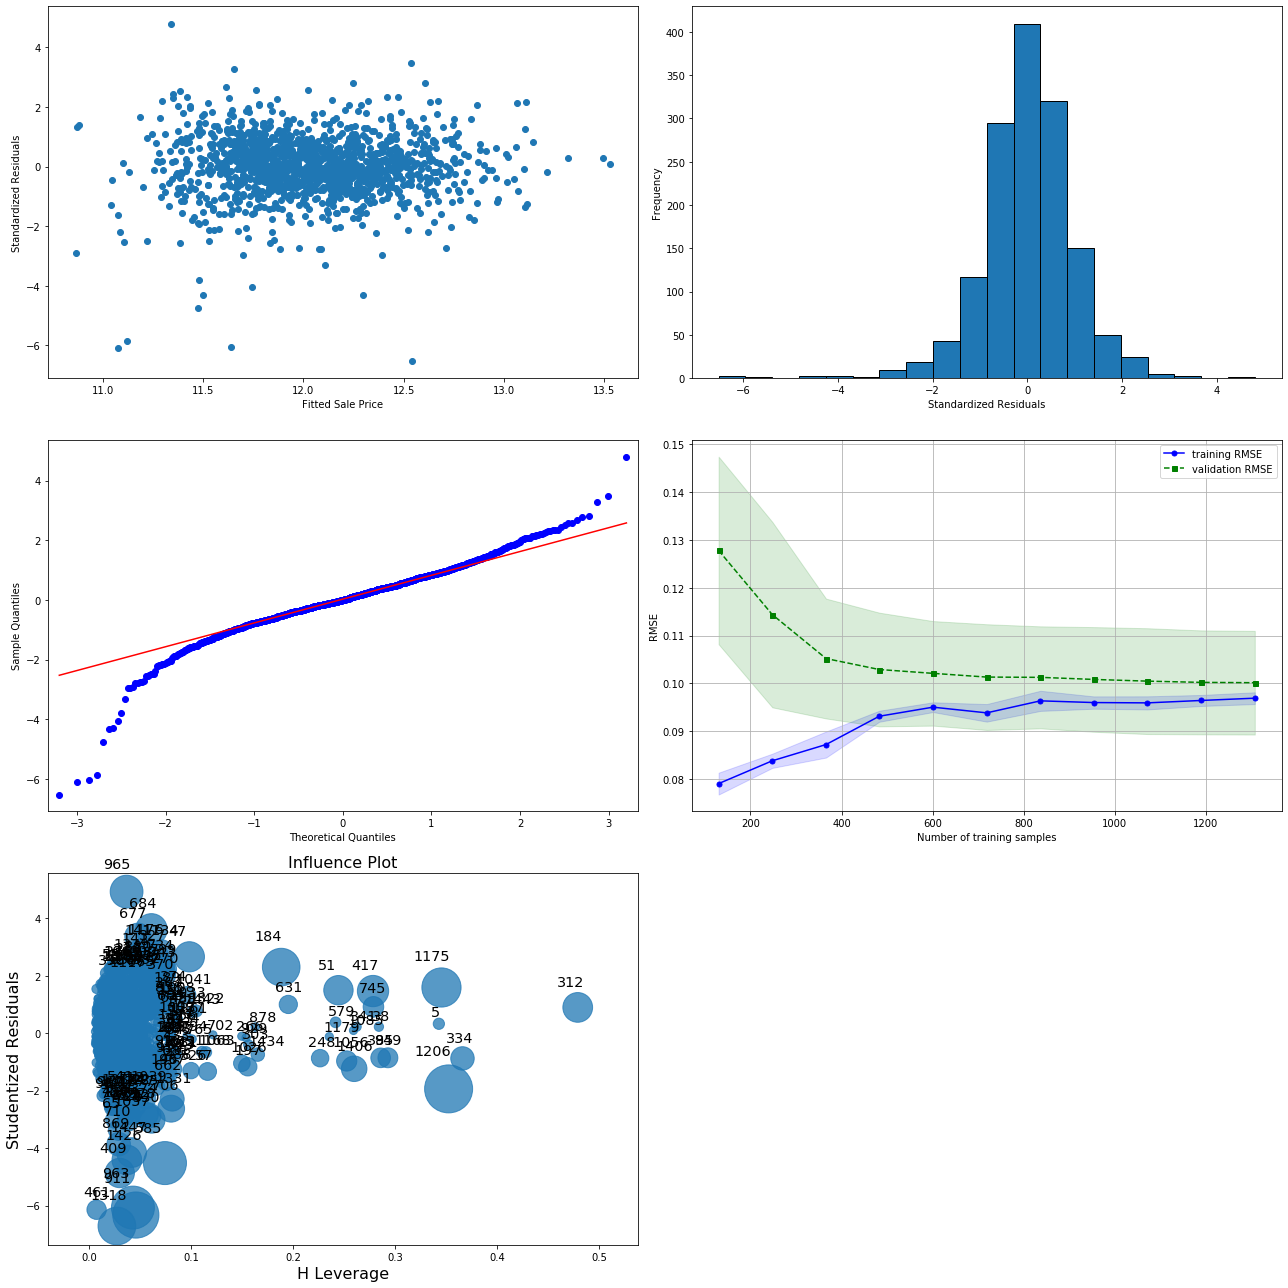

In [2]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
train_labels = train_df[['Id','SalePrice']]
test_id = pd.DataFrame(test_df['Id'])
all_data = train_df.append(test_df, sort=False)
all_data.drop(columns='SalePrice', inplace=True)

# Impute missing values (excluding LotFrontage)
from missing_data import MissingDataImputer
missing_imputer = MissingDataImputer()
all_data = missing_imputer.fit_transform(all_data)

# Transform categorical variables
from categorical_transformer import CatTransformer
cat_transf = CatTransformer()
all_data = cat_transf.fit_transform(all_data)

train_df = all_data[all_data['Id'].isin(train_df['Id'])]
test_df = all_data[all_data['Id'].isin(test_df['Id'])]

train_df.drop(columns='Id', inplace=True)
test_df.drop(columns='Id', inplace=True)

# Best features (sfs)
# sfs_log_features = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'KitchenAbvGr', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'Alley', 'LandSlope', 'BsmtExposure', 'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageQual', 'HouseStyle_2.5Fin', 'HouseStyle_SFoyer', 'HouseStyle_SLvl', 'Street_Pave', 'MSZoning_RM', 'LotConfig_CulDSac', 'LotConfig_FR3', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_Crawfor', 'Neighborhood_MeadowV', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Veenker', 'Condition1_Norm', 'Condition1_RRAe', 'BldgType_TwnhsE', 'RoofStyle_Gable', 'RoofMatl_WdShngl', 'Exterior1st_BrkFace', 'Exterior1st_HdBoard', 'Exterior1st_Wd Sdng', 'Exterior2nd_AsphShn', 'Exterior2nd_BrkFace', 'MasVnrType_Stone', 'Foundation_PConc', 'Foundation_Wood', 'Heating_OthW', 'Heating_Wall', 'CentralAir_Y', 'SaleType_Con', 'SaleType_ConLD', 'SaleType_New', 'SaleCondition_AdjLand', 'SaleCondition_Family', 'SaleCondition_Normal', 'MSSubClass_150', 'MSSubClass_160', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_45', 'MSSubClass_70', 'MoSold_4', 'MoSold_5', 'YrSold_2009']
# Parsimonious features (sfs)
sfs_log_features = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'TotalBsmtSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'KitchenAbvGr', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'ScreenPorch', 'Alley', 'BsmtExposure', 'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageQual', 'HouseStyle_2.5Fin', 'Street_Pave', 'MSZoning_RM', 'LotConfig_CulDSac', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_Crawfor', 'Neighborhood_MeadowV', 'Neighborhood_NridgHt', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Condition1_Norm', 'Exterior1st_BrkFace', 'Foundation_PConc', 'Foundation_Wood', 'Heating_Wall', 'CentralAir_Y', 'SaleType_New', 'SaleCondition_AdjLand', 'SaleCondition_Normal', 'MSSubClass_160', 'MSSubClass_20', 'MSSubClass_30', 'MoSold_5']
# Drop majority binary labels
#sfs_log_features = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'TotalBsmtSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'KitchenAbvGr', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'ScreenPorch', 'Alley', 'BsmtExposure', 'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageQual', 'MSZoning_RM', 'LotConfig_CulDSac', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_Crawfor', 'Neighborhood_MeadowV', 'Neighborhood_NridgHt', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Condition1_Norm', 'Exterior1st_BrkFace', 'Foundation_PConc', 'CentralAir_Y', 'SaleType_New', 'SaleCondition_Normal', 'MSSubClass_160', 'MSSubClass_20', 'MSSubClass_30', 'MoSold_5']

train_df_sfs = train_df[sfs_log_features].copy()
test_df_sfs = test_df[sfs_log_features].copy()
train_label = train_labels.copy()

# Drop high VIF
train_df_sfs.drop(columns='GarageYrBlt', inplace=True)
test_df_sfs.drop(columns='GarageYrBlt', inplace=True)

# Impute LotFrontage
imputer = SimpleImputer(strategy='median')
train_df_sfs['LotFrontage'] = imputer.fit_transform(train_df_sfs['LotFrontage'].values.reshape(-1,1))
test_df_sfs['LotFrontage'] = imputer.transform(test_df_sfs['LotFrontage'].values.reshape(-1,1))

# Feature engineering
train_df_sfs['log_LotArea'] = np.log(train_df_sfs['LotArea'].values)
test_df_sfs['log_LotArea'] = np.log(test_df_sfs['LotArea'].values)
train_df_sfs['GrLivArea_SaleType_New'] = train_df_sfs['GrLivArea'] * train_df_sfs['SaleType_New']
test_df_sfs['GrLivArea_SaleType_New'] = test_df_sfs['GrLivArea'] * test_df_sfs['SaleType_New']
#train_df_sfs['GrLivArea_CentralAir_Y'] = train_df_sfs['GrLivArea'] * train_df_sfs['CentralAir_Y']
#test_df_sfs['GrLivArea_CentralAir_Y'] = test_df_sfs['GrLivArea'] * test_df_sfs['CentralAir_Y']
#train_df_sfs['boxcox_LotFrontage'] = boxcox(train_df_sfs['LotFrontage'].values)[0]
#test_df_sfs['boxcox_LotFrontage'] = boxcox(test_df_sfs['LotFrontage'].values)[0]
#train_df_sfs.drop(columns='LotArea', inplace=True)
#test_df_sfs.drop(columns='LotArea', inplace=True)

# Drop influential points
influential_points = [1298, 523, 30, 632, 812, 495]
#influential_points = [1298, 523, 30, 632, 812, 495, 916, 1324, 462, 968] # drop_MORE
train_df_sfs.drop(influential_points, inplace=True)
train_label.drop(influential_points, inplace=True)

# Scale
scaler = StandardScaler()
cat_feats = list(train_df_sfs.select_dtypes(include='uint8').columns)
num_feats = list(train_df_sfs.select_dtypes(exclude='uint8').columns)
train_df_sfs_scaled = scaler.fit_transform(train_df_sfs[num_feats])
test_df_sfs_scaled = scaler.transform(test_df_sfs[num_feats])
train_df_sfs = np.column_stack((train_df_sfs_scaled, train_df_sfs[cat_feats].values))
test_df_sfs = np.column_stack((test_df_sfs_scaled, test_df_sfs[cat_feats].values))
train_df_sfs = pd.DataFrame(train_df_sfs, columns = num_feats+cat_feats)
test_df_sfs = pd.DataFrame(test_df_sfs, columns = num_feats+cat_feats)
del(train_df_sfs_scaled)
del(test_df_sfs_scaled)

X_train = train_df_sfs.values
X_test = test_df_sfs.values
y_train = np.log(train_label['SalePrice'].values)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

lin_regr = sm.OLS(y_train, X_train).fit()
lin_regr_sk = LinearRegression()
lin_regr_sk.fit(train_df_sfs.values, y_train)

print(np.sqrt(mean_squared_error(train_label['SalePrice'].values, np.exp(lin_regr.predict()))))

fig=plt.figure(figsize=(18,18))

ax1 = plt.subplot(321)
ax1.scatter(lin_regr.predict(), lin_regr.resid_pearson)
ax1.set_xlabel("Fitted Sale Price")
ax1.set_ylabel("Standardized Residuals")

ax2 = plt.subplot(322)
ax2.hist(lin_regr.resid_pearson, bins=20, edgecolor='k')
ax2.set_xlabel("Standardized Residuals")
ax2.set_ylabel("Frequency")

ax3 = plt.subplot(323)
fig = sm.qqplot(lin_regr.resid_pearson, line='q', ax=ax3)

ax4 = plt.subplot(324)
lc_params = compute_learning_curve(estimator=lin_regr_sk, 
                                   X=train_df_sfs.values, 
                                   y=y_train,
                                   cv=10)
plot_learning_curve(ax4, lc_params)

ax5 = plt.subplot(325)
fig = sm.graphics.influence_plot(lin_regr, ax=ax5, criterion="cooks")
plt.tight_layout()

In [ ]:
a = OLSInfluence(lin_regr).summary_frame()
a.student_resid.sort_values().head(30)

18349.512823315396

18134.811739512297 Add boxcox_LotArea

18191.27011770612 Drop GarageYrBlt, Add log_LotArea

18053.275588027016 Drop GarageYrBlt, Add log_LotArea, add GrLivArea_SaleType_New

18080.897569665878 Drop GarageYrBlt, Add log_LotArea, add GrLivArea_SaleType_New. add GrLivArea_CentralAir_Y

18038.057905790884 Drop GarageYrBlt, Add log_LotArea, add GrLivArea_SaleType_New. add GrLivArea_CentralAir_Y, drop 812 

**18005.550148533453 Drop GarageYrBlt, Add log_LotArea, add GrLivArea_SaleType_New. add GrLivArea_CentralAir_Y, drop 812, 495**

17546.78022490303 same as above, drop 916, 1324, 462, 968

<br>
<br>

**Feature importance**

In [3]:
coef_dict = {}
coef_dict['intercept'] = lin_regr.params[0]

for idx, coef in enumerate(lin_regr.params[1:]):
    coef_dict[list(train_df_sfs.columns)[idx]] = coef
coef_series = pd.Series(coef_dict)
del(coef_dict)

In [4]:
np.abs(coef_series).sort_values(ascending=False).head(30)

intercept                 11.666941
Street_Pave                0.169120
Neighborhood_Crawfor       0.141941
GrLivArea                  0.132264
Foundation_Wood            0.130068
Neighborhood_StoneBr       0.114380
SaleCondition_AdjLand      0.094559
Heating_Wall               0.094386
Exterior1st_BrkFace        0.086702
Neighborhood_MeadowV       0.077181
Neighborhood_NridgHt       0.074492
OverallQual                0.074085
Neighborhood_BrkSide       0.071727
SaleCondition_Normal       0.071720
Neighborhood_Somerst       0.064932
YearBuilt                  0.063715
CentralAir_Y               0.061095
HouseStyle_2.5Fin          0.059789
Neighborhood_ClearCr       0.054909
MSSubClass_160             0.050059
SaleType_New               0.046565
MSSubClass_30              0.045170
Condition1_Norm            0.044736
OverallCond                0.042562
TotalBsmtSF                0.040533
BsmtFinSF1                 0.032141
LotConfig_CulDSac          0.029859
log_LotArea                0

<br>
<br>

**Plot potential interactions**

c:\users\wongt\desktop\advanced_regression_techniques_conda\venv\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning:

invalid value encountered in true_divide

c:\users\wongt\desktop\advanced_regression_techniques_conda\venv\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning:

invalid value encountered in double_scalars



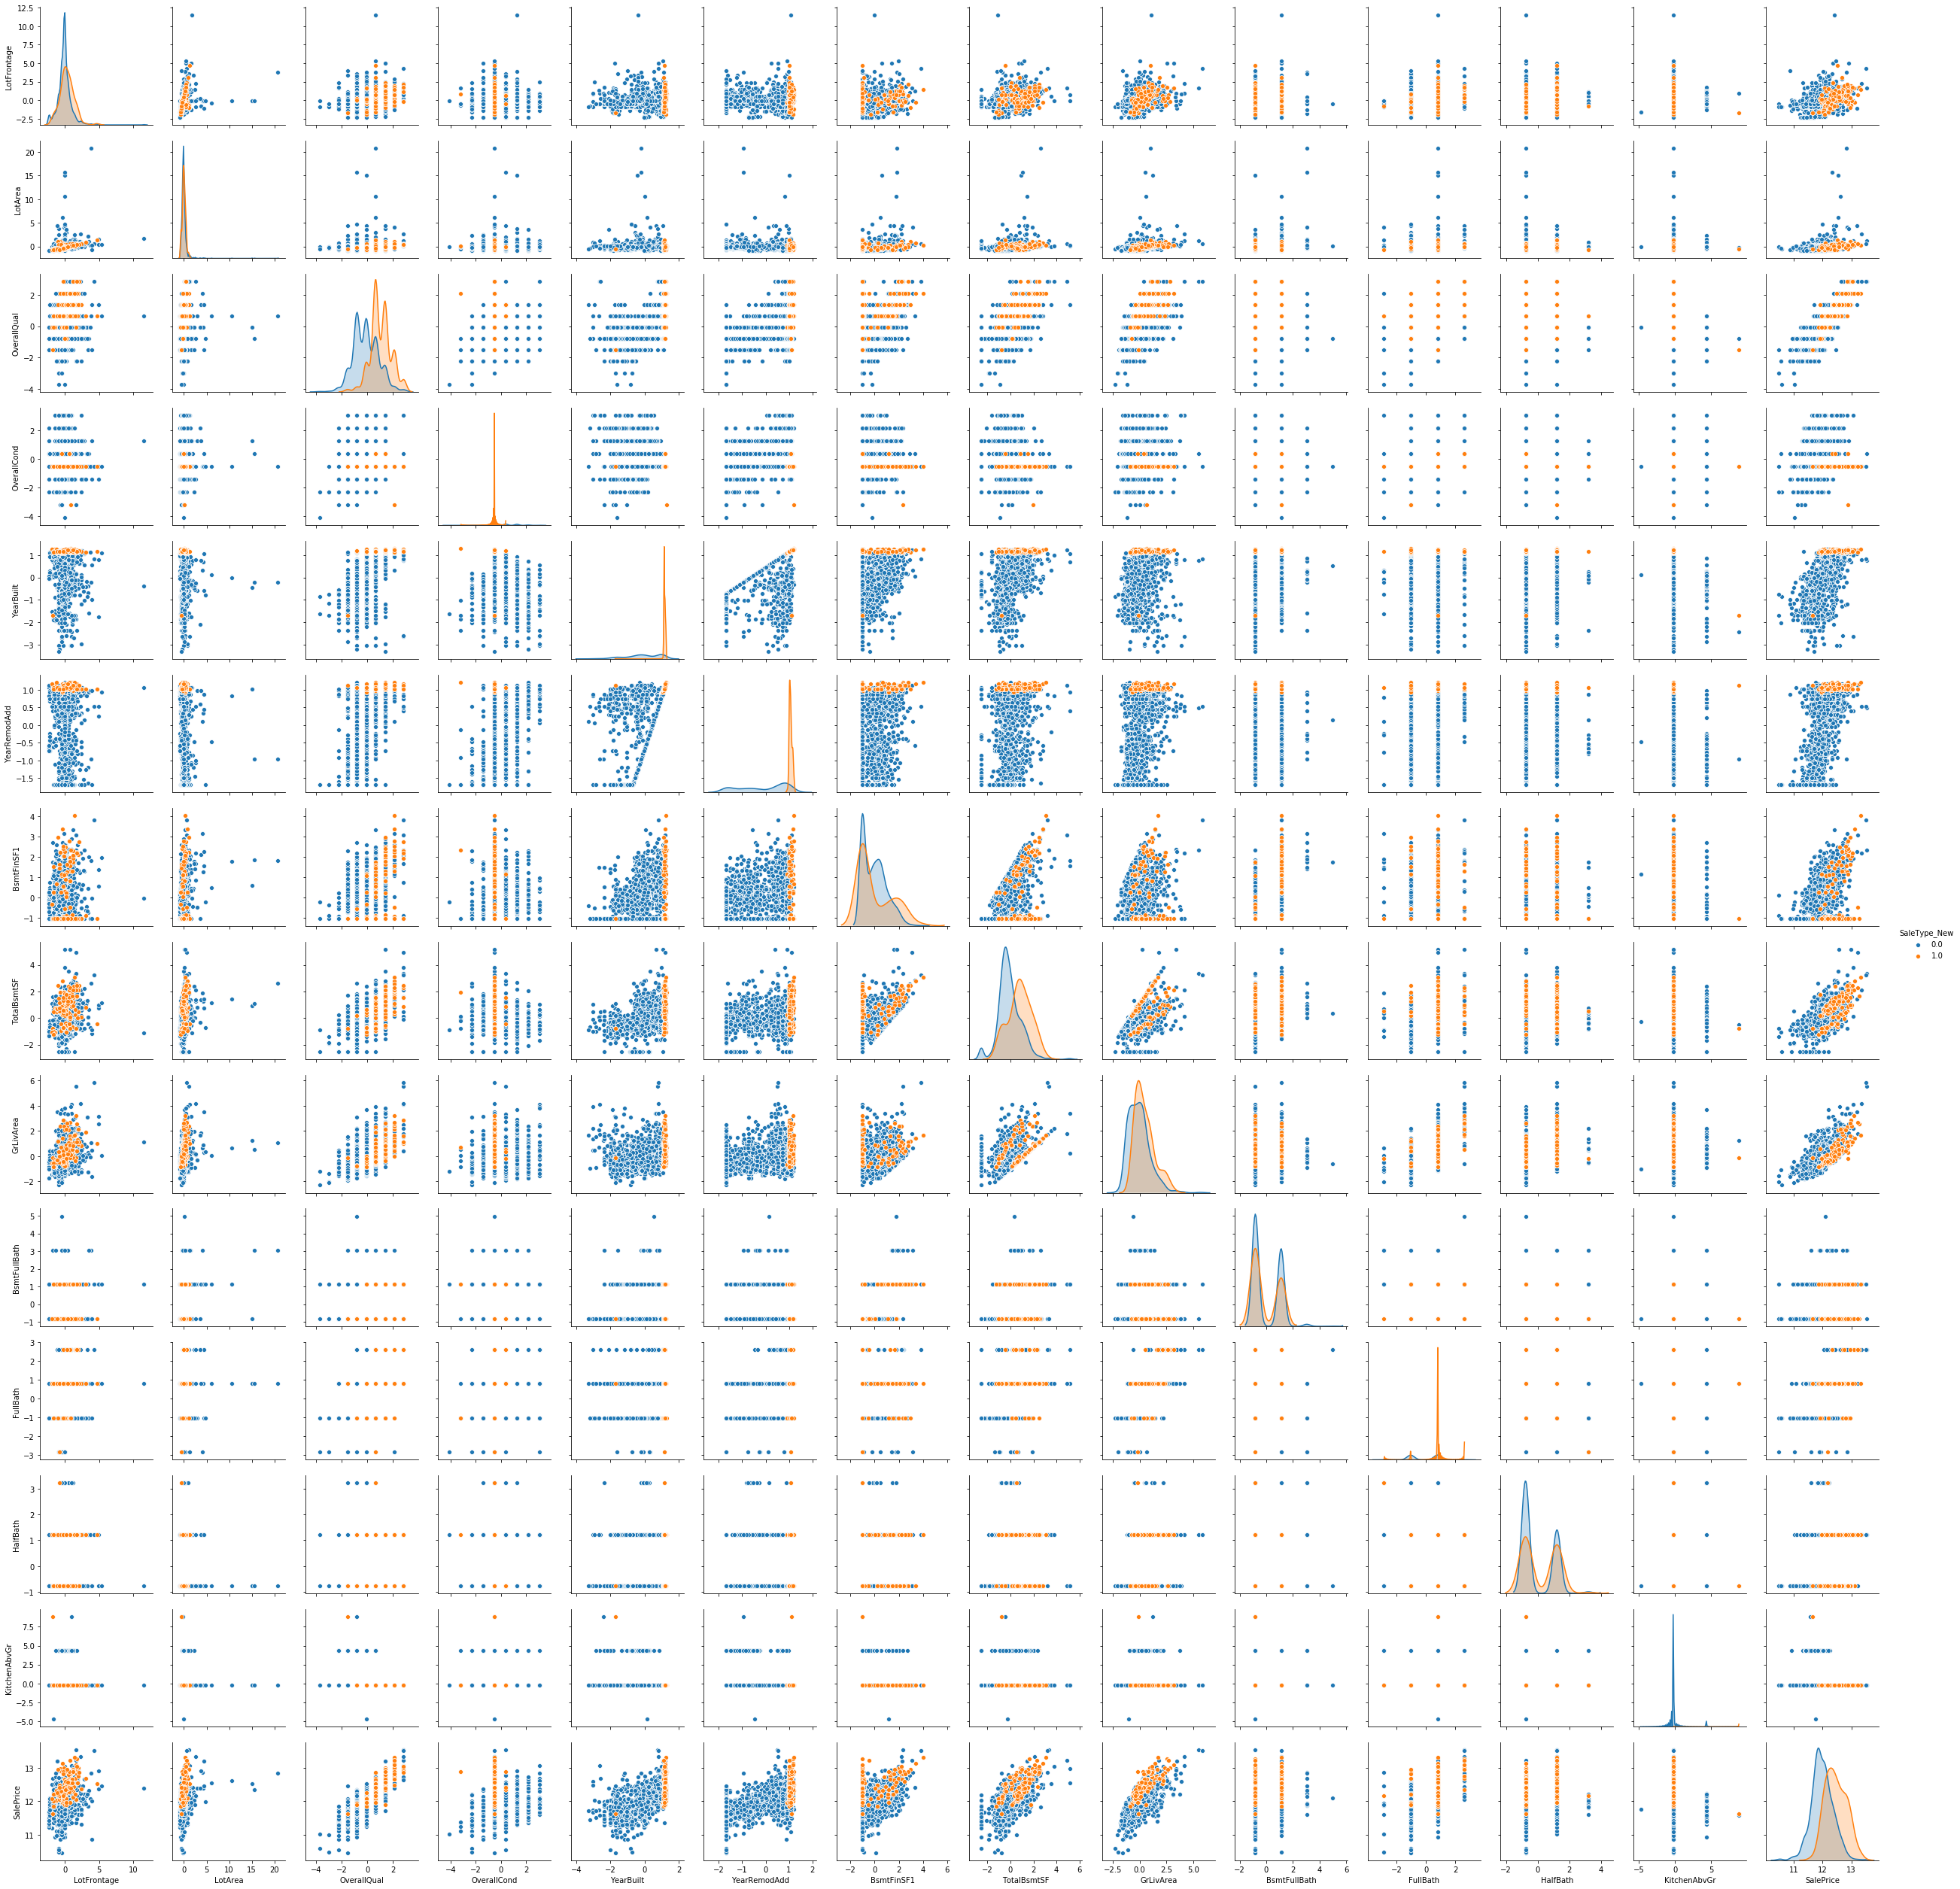

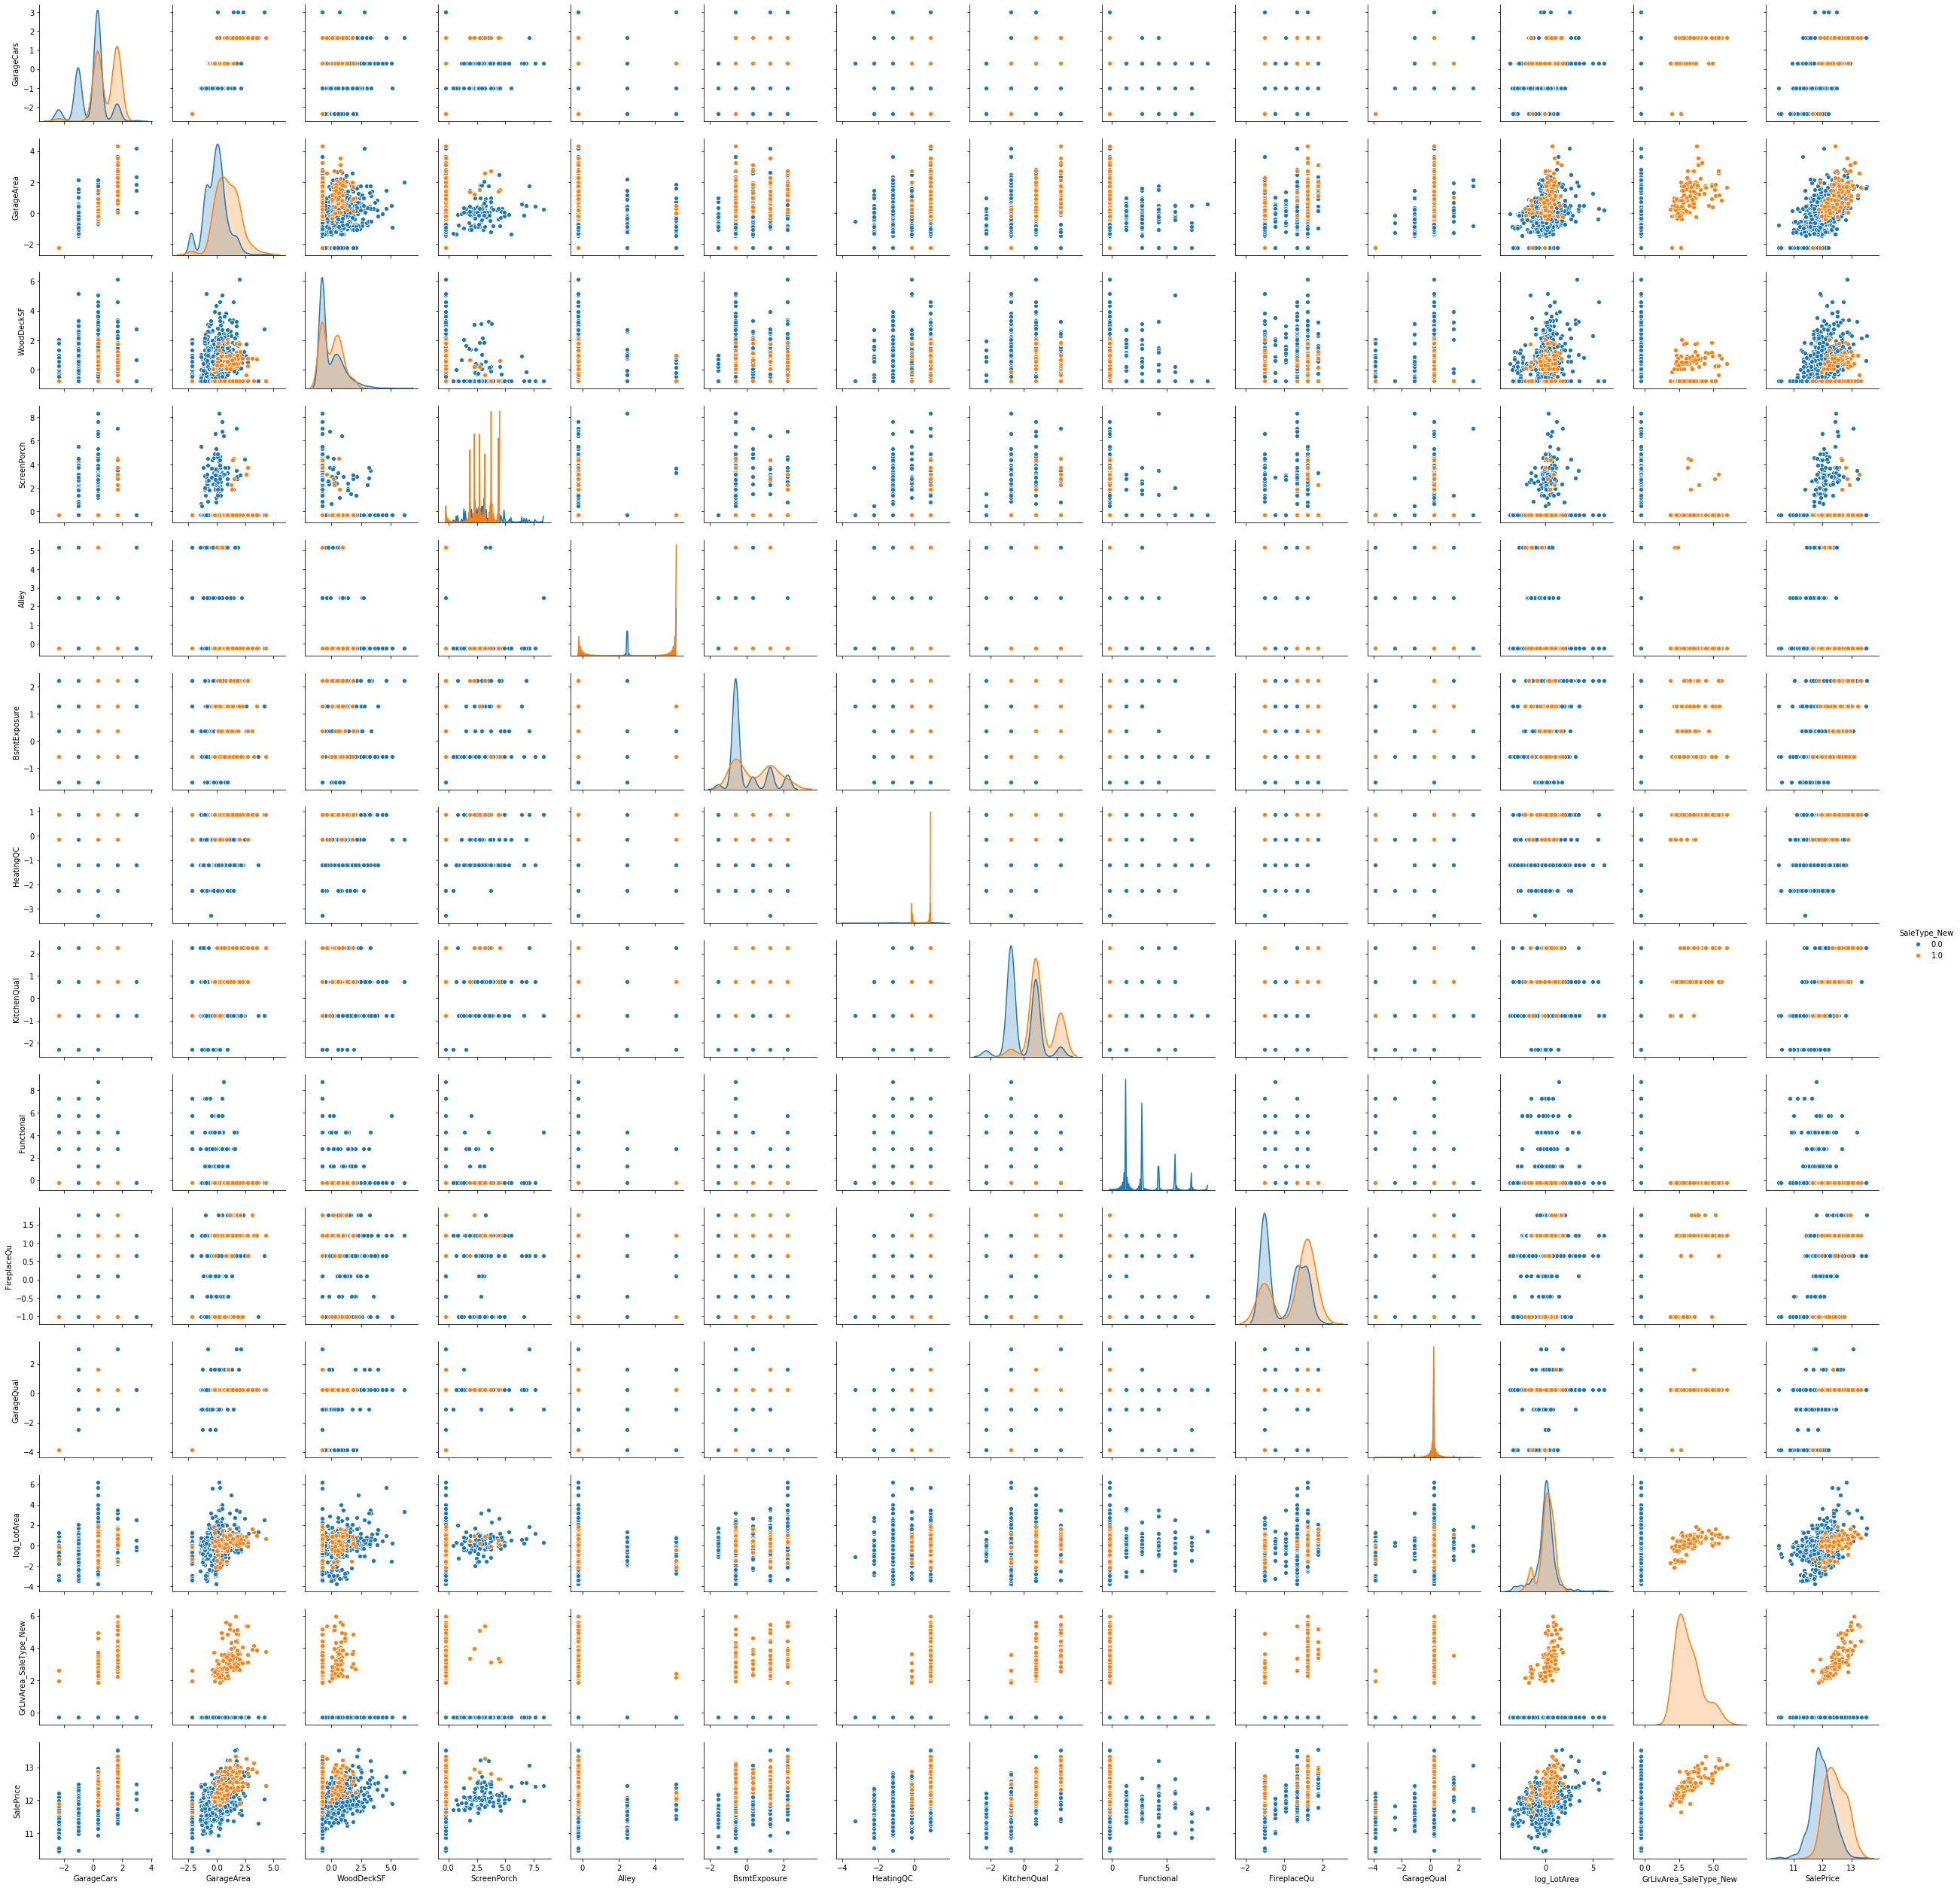

In [5]:
train_df_sfs_copy = train_df_sfs.copy()
train_df_sfs_copy['SalePrice'] = np.log(train_label['SalePrice'].values)
sns.pairplot(train_df_sfs_copy[num_feats[:13]+['SaleType_New','SalePrice']], 
             vars=num_feats[:13]+['SalePrice'],
             hue='SaleType_New'
            )
sns.pairplot(train_df_sfs_copy[num_feats[13:]+['SaleType_New','SalePrice']], 
             vars=num_feats[13:]+['SalePrice'],
             hue='SaleType_New'
            )

<br>
<br>

**Check VIFs**

In [6]:
vif_dict = {}
for idx, feat in enumerate(train_df_sfs.columns):
    vif_dict[feat] = variance_inflation_factor(sm.add_constant(train_df_sfs.values), idx+1);
vif_series = pd.Series(vif_dict)
del(vif_dict)
vif_series.sort_values(ascending=False)

SaleType_New              17.913593
GrLivArea_SaleType_New    17.488275
GarageCars                 6.181189
GarageArea                 5.729275
YearBuilt                  5.587767
log_LotArea                5.425412
GrLivArea                  5.420997
OverallQual                3.843914
FullBath                   2.998852
TotalBsmtSF                2.953346
YearRemodAdd               2.790432
Foundation_PConc           2.603779
LotArea                    2.601659
KitchenQual                2.529371
MSSubClass_20              2.397628
BsmtFinSF1                 2.238283
MSSubClass_160             2.048835
HalfBath                   2.041123
BsmtFullBath               1.956535
GarageQual                 1.936150
SaleCondition_Normal       1.878658
OverallCond                1.873203
LotFrontage                1.804758
MSZoning_RM                1.783549
HeatingQC                  1.768455
FireplaceQu                1.679311
Neighborhood_Somerst       1.587803
BsmtExposure               1

<br>
<br>

**Skewed features**

In [7]:
skew_dict = {}
for col in train_df_sfs.columns:
    skew_dict[col] = skew(train_df_sfs[col].values)#
skew_series = pd.Series(skew_dict)
del(skew_dict)

In [8]:
skew_series.sort_values()

Street_Pave              -15.481305
CentralAir_Y              -3.543780
GarageQual                -3.219647
Condition1_Norm           -2.132448
SaleCondition_Normal      -1.684635
YearBuilt                 -0.612833
HeatingQC                 -0.541512
YearRemodAdd              -0.503443
GarageCars                -0.342943
log_LotArea               -0.180853
FullBath                   0.031191
FireplaceQu                0.115346
GarageArea                 0.130989
OverallQual                0.201457
Foundation_PConc           0.229519
KitchenQual                0.381441
TotalBsmtSF                0.511591
MSSubClass_20              0.549896
BsmtFullBath               0.587542
HalfBath                   0.677165
OverallCond                0.689530
BsmtFinSF1                 0.764878
GrLivArea                  1.008304
BsmtExposure               1.104250
WoodDeckSF                 1.545047
LotFrontage                1.720265
MSZoning_RM                1.963413
MoSold_5                   2

<br>
<br>

**Make submission**

In [3]:
today = datetime.datetime.today()

submission_df = test_id.copy()
submission_df['SalePrice'] = np.exp(lin_regr.predict(X_test))
submission_df.to_csv("submissions/{}{}{}_attempt7_OLSR_OLSRfeats_FE_drop_MORE.csv".format(today.year,today.month,today.day), index=False)

0.12196 **OLSR sfs parsimonious features (non-floating). No FE, drop [1298, 523, 30, 632]**

0.12372 **OLSR sfs BEST features (non-floating). No FE, drop [1298, 523, 30, 632]**

0.12221 **OLSR sfs parsimonious features (non-floating). No FE, drop [1298, 523, 30, 632], drop 'Foundation_Wood', 'Heating_Wall', 'HouseStyle_2.5Fin', 'SaleCondition_AdjLand', 'Street_Pave'**

 FAILED **OLSR sfs parsimonious features (non-floating), drop [1298, 523, 30, 632], Drop "GarageYrBlt". Add 'boxcox_LotArea'**

0.12117 **OLSR sfs parsimonious features (non-floating), drop [1298, 523, 30, 632], Drop "GarageYrBlt". Add 'log_LotArea'. Add 'GrLivArea_SaleType_New'**

0.12104 **OLSR sfs parsimonious features (non-floating), drop [1298, 523, 30, 632, 812, 495], Drop "GarageYrBlt". Add 'log_LotArea'. Add 'GrLivArea_SaleType_New'** (drop_more)

0.12164 **OLSR sfs parsimonious features (non-floating), drop [1298, 523, 30, 632, 812, 495, 916, 1324, 462, 968], Drop "GarageYrBlt". Add 'log_LotArea'. Add 'GrLivArea_SaleType_New'**

___

## Other ML models

<br>
<br>

**GBRT**

In [3]:
gbr = GradientBoostingRegressor(learning_rate=0.05)

#gbr_gs = GridSearchCV(gbr, {'n_estimators':[300,325,350,375,400,425,450,475,500]}, scoring='neg_mean_squared_error', n_jobs=4, iid=False, cv=10)
gbr_gs = GridSearchCV(gbr, {'n_estimators':[300,400,500,600,700,800,900]}, scoring='neg_mean_squared_error', n_jobs=4, iid=False, cv=10)
best_gbr = gbr_gs.fit(train_df_sfs.values, y_train)

{'n_estimators': 700}


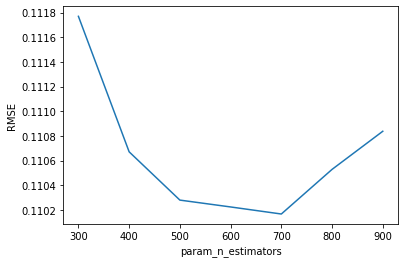

In [4]:
gbr_gs_results = pd.DataFrame(best_gbr.cv_results_)
gbr_gs_results['RMSE'] = np.sqrt(-gbr_gs_results['mean_test_score'])
print(best_gbr.best_params_)
sns.lineplot(x='param_n_estimators', y='RMSE', data=gbr_gs_results);

In [5]:
gbr = GradientBoostingRegressor(learning_rate=0.05, n_estimators=550)
gbr.fit(train_df_sfs.values, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.05, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=550,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [7]:
today = datetime.datetime.today()

submission_df = test_id.copy()
submission_df['SalePrice'] = np.exp(gbr.predict(test_df_sfs.values))
submission_df.to_csv("submissions/{}{}{}_attempt8_GBR_OLSRfeats_FE_drop.csv".format(today.year,today.month,today.day), index=False)

**0.12704**

<br>
<br>

**Random Forest**

In [3]:
rand_for = RandomForestRegressor(n_estimators=2000, max_features='sqrt')
rand_for.fit(train_df_sfs.values, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=2000,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [4]:
today = datetime.datetime.today()

submission_df = test_id.copy()
submission_df['SalePrice'] = np.exp(rand_for.predict(test_df_sfs.values))
submission_df.to_csv("submissions/{}{}{}_attempt9_RF_OLSRfeats_FE_drop_more.csv".format(today.year,today.month,today.day), index=False)

**0.14460**

<br>
<br>

**GLM**

In [2]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
train_labels = train_df[['Id','SalePrice']]
test_id = pd.DataFrame(test_df['Id'])
all_data = train_df.append(test_df, sort=False)
all_data.drop(columns='SalePrice', inplace=True)

# Impute missing values (excluding LotFrontage)
from missing_data import MissingDataImputer
missing_imputer = MissingDataImputer()
all_data = missing_imputer.fit_transform(all_data)

# Transform categorical variables
from categorical_transformer import CatTransformer
cat_transf = CatTransformer()
all_data = cat_transf.fit_transform(all_data)

train_df = all_data[all_data['Id'].isin(train_df['Id'])]
test_df = all_data[all_data['Id'].isin(test_df['Id'])]

train_df.drop(columns='Id', inplace=True)
test_df.drop(columns='Id', inplace=True)

# Best features (sfs)
# sfs_log_features = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'KitchenAbvGr', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'Alley', 'LandSlope', 'BsmtExposure', 'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageQual', 'HouseStyle_2.5Fin', 'HouseStyle_SFoyer', 'HouseStyle_SLvl', 'Street_Pave', 'MSZoning_RM', 'LotConfig_CulDSac', 'LotConfig_FR3', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_Crawfor', 'Neighborhood_MeadowV', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Veenker', 'Condition1_Norm', 'Condition1_RRAe', 'BldgType_TwnhsE', 'RoofStyle_Gable', 'RoofMatl_WdShngl', 'Exterior1st_BrkFace', 'Exterior1st_HdBoard', 'Exterior1st_Wd Sdng', 'Exterior2nd_AsphShn', 'Exterior2nd_BrkFace', 'MasVnrType_Stone', 'Foundation_PConc', 'Foundation_Wood', 'Heating_OthW', 'Heating_Wall', 'CentralAir_Y', 'SaleType_Con', 'SaleType_ConLD', 'SaleType_New', 'SaleCondition_AdjLand', 'SaleCondition_Family', 'SaleCondition_Normal', 'MSSubClass_150', 'MSSubClass_160', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_45', 'MSSubClass_70', 'MoSold_4', 'MoSold_5', 'YrSold_2009']
# Parsimonious features (sfs)
sfs_log_features = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'TotalBsmtSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'KitchenAbvGr', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'ScreenPorch', 'Alley', 'BsmtExposure', 'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageQual', 'HouseStyle_2.5Fin', 'Street_Pave', 'MSZoning_RM', 'LotConfig_CulDSac', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_Crawfor', 'Neighborhood_MeadowV', 'Neighborhood_NridgHt', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Condition1_Norm', 'Exterior1st_BrkFace', 'Foundation_PConc', 'Foundation_Wood', 'Heating_Wall', 'CentralAir_Y', 'SaleType_New', 'SaleCondition_AdjLand', 'SaleCondition_Normal', 'MSSubClass_160', 'MSSubClass_20', 'MSSubClass_30', 'MoSold_5']
# Drop majority binary labels
#sfs_log_features = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'TotalBsmtSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'KitchenAbvGr', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'ScreenPorch', 'Alley', 'BsmtExposure', 'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageQual', 'MSZoning_RM', 'LotConfig_CulDSac', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_Crawfor', 'Neighborhood_MeadowV', 'Neighborhood_NridgHt', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Condition1_Norm', 'Exterior1st_BrkFace', 'Foundation_PConc', 'CentralAir_Y', 'SaleType_New', 'SaleCondition_Normal', 'MSSubClass_160', 'MSSubClass_20', 'MSSubClass_30', 'MoSold_5']

train_df_sfs = train_df[sfs_log_features].copy()
test_df_sfs = test_df[sfs_log_features].copy()
train_label = train_labels.copy()

# Drop high VIF
train_df_sfs.drop(columns='GarageYrBlt', inplace=True)
test_df_sfs.drop(columns='GarageYrBlt', inplace=True)

# Impute LotFrontage
imputer = SimpleImputer(strategy='median')
train_df_sfs['LotFrontage'] = imputer.fit_transform(train_df_sfs['LotFrontage'].values.reshape(-1,1))
test_df_sfs['LotFrontage'] = imputer.transform(test_df_sfs['LotFrontage'].values.reshape(-1,1))

# Feature engineering
train_df_sfs['log_LotArea'] = np.log(train_df_sfs['LotArea'].values)
test_df_sfs['log_LotArea'] = np.log(test_df_sfs['LotArea'].values)
train_df_sfs['GrLivArea_SaleType_New'] = train_df_sfs['GrLivArea'] * train_df_sfs['SaleType_New']
test_df_sfs['GrLivArea_SaleType_New'] = test_df_sfs['GrLivArea'] * test_df_sfs['SaleType_New']
#train_df_sfs['GrLivArea_CentralAir_Y'] = train_df_sfs['GrLivArea'] * train_df_sfs['CentralAir_Y']
#test_df_sfs['GrLivArea_CentralAir_Y'] = test_df_sfs['GrLivArea'] * test_df_sfs['CentralAir_Y']
#train_df_sfs['boxcox_LotFrontage'] = boxcox(train_df_sfs['LotFrontage'].values)[0]
#test_df_sfs['boxcox_LotFrontage'] = boxcox(test_df_sfs['LotFrontage'].values)[0]
#train_df_sfs.drop(columns='LotArea', inplace=True)
#test_df_sfs.drop(columns='LotArea', inplace=True)

# Drop influential points
influential_points = [1298, 523, 30, 632, 812, 495]
#influential_points = [1298, 523, 30, 632, 812, 495, 916, 1324, 462, 968]
train_df_sfs.drop(influential_points, inplace=True)
train_label.drop(influential_points, inplace=True)

# Scale
scaler = StandardScaler()
cat_feats = list(train_df_sfs.select_dtypes(include='uint8').columns)
num_feats = list(train_df_sfs.select_dtypes(exclude='uint8').columns)
train_df_sfs_scaled = scaler.fit_transform(train_df_sfs[num_feats])
test_df_sfs_scaled = scaler.transform(test_df_sfs[num_feats])
train_df_sfs = np.column_stack((train_df_sfs_scaled, train_df_sfs[cat_feats].values))
test_df_sfs = np.column_stack((test_df_sfs_scaled, test_df_sfs[cat_feats].values))
train_df_sfs = pd.DataFrame(train_df_sfs, columns = num_feats+cat_feats)
test_df_sfs = pd.DataFrame(test_df_sfs, columns = num_feats+cat_feats)
del(train_df_sfs_scaled)
del(test_df_sfs_scaled)

X_train = train_df_sfs.values
X_test = test_df_sfs.values
y_train = train_label['SalePrice'].values
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

#lin_regr = sm.OLS(y_train, X_train).fit()
glm = sm.GLM(y_train, X_train, family=sm.families.Gaussian(sm.families.links.log)).fit()
#glm = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

c:\users\wongt\desktop\advanced_regression_techniques_conda\venv\lib\site-packages\ipykernel_launcher.py:82: DeprecationWarning:

Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.



Text(0.5, 1.0, 'GLM Residuals')

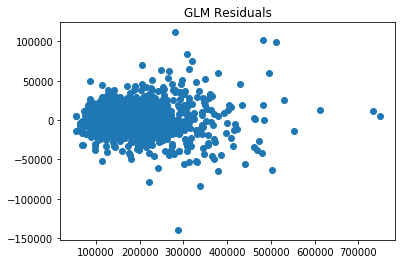

In [3]:
ax1 = plt.subplot(111)
ax1.scatter(glm.predict(), y_train-glm.predict())
ax1.set_title("GLM Residuals")

In [5]:
today = datetime.datetime.today()

submission_df = test_id.copy()
submission_df['SalePrice'] = glm.predict(X_test)
submission_df.to_csv("submissions/{}{}{}_attempt10_GLM_OLSRfeats_FE_drop_more.csv".format(today.year,today.month,today.day), index=False)

**0.12195**

<br>
<br>

# Regression Workflow

Before EDA

- Fill in missing data:
    - see [types of missing data](https://www.displayr.com/different-types-of-missing-data/)
    - Handle MNAR entries (fill in with appropriate value e.g. None or 0)
    - Impute MAR entries (central tendency, MICE, KNN etc) See [fancyimpute](https://github.com/iskandr/fancyimpute)
- Transform Categorical variables
    - Ordinal mappings for ordinal categorical variables or Dummy encoding for nominal categorical variables
    - For high cardinality categorical variables see [categorical encoders](https://github.com/scikit-learn-contrib/categorical-encoding)
    
EDA

- Check response:
    - Is it normally distributed? bounded below? skewed?
    - A transformation might help the problems above
    - A GLM might be appropriate for bounded and skewed responses
- Check numerical variables
    - Correlation heatmap
    - Scatterplot matrix for highly correlated (with response) features
    - etc
- Check categorical variables
    - Ordered Boxplots
    - Barcharts
    - etc

First model

- Check and assess [model assumptions](https://newonlinecourses.science.psu.edu/stat501/node/317/)
- Determine next steps from the initial model
    - if features need to be pruned, perform feature selection
    - if non-linearity exists, explore hard fitting models
    - if heteroscedasticity is present, explore response and/or feature transformations or GLMs
    - if autocorrelation exists, explore time-series methods

Subsequent models

- Check for influential points
- Perform feature engineering (interactions + non-linear features) using the reduced set of features
- After identifying useful features using feature selection:
    - Produce residual plot against remaining (or engineered) predictors to identify any potential useful predictors to be added
- Try ML models with high predictive power:
    - GLM/GAM
    - Random Forest
    - GBDT
    - XGBoost, LightGBM, Catboost
- Run more sophisticated models to check the performance deficit between interpretable models and hard-fitting models
    
Conclusion

- Evaluate interpretable models (OLSR, GLM) by [visualizing the coefficients](https://christophm.github.io/interpretable-ml-book/limo.html)
- Perform inference on interpretable models:
    - Check p-values of coefficients
    - Perform sequential sum of squares F-test on nested models where applicable (e.g. on dropped high p-value features)
    - Feature importance can be compared using standardized coefficients
- Identify important features and produce useful predictions
    - For features with high coefficient values, interpret the coefficients
    - Check prediciton intervals for practically (and statistically) significant changes to the response when varying a certain important features
- Evaluate uninterpretable models using [model-agnostic interpretation methods](https://christophm.github.io/interpretable-ml-book/agnostic.html)

# To do

- ~~FIX N_JOBS - STILL BROKEN, use Conda environment~~
- ~~Run SFS (understand the floating one?)~~
- ~~Run LassoLarsCV, LassoLarsIc, LarsPath etc.~~
- ~~Run Random Forest feature selection~~
- ~~Change OLSR evaluation to a subplot and fix the code~~
- ~~Seq Sum of Sqs test after removing SFS or Lasso features (May not work due to feature names)~~
- ~~Read up on the next logical step to deal with non linearity (is polynomial features the next step??)~~
- ~~Read up on lognormal glm~~
- ~~Use reduced features to produce non-linear model~~ - Ok results
- ~~Check for skewed numerical features using a pairplot~~ - Tried boxcox for skewed features (GrLivArea, LotArea). Didn't improve results much
- ~~Deal with skewed features using transforms~~ - Test results doesn't improve much
- ~~Run GLM again~~ - Test results not good

**RESELECT FEATURES USING LOG RESPONSE**

- ~~Perform the same process using Lasso features~~
- ~~Select features using log response~~ - Since log response transform gives better test results, redo feature selection using log response
- ~~Check the add_constant issue~~ - Either calculate VIF and see what which feature fails OR run sm.OLS and see which feature is recognised as a constant
- ~~Make submission using log response selected lasso features~~ - Good results using OLS
- ~~Make submission using log response selected lasso features with GLM~~ - Bad results using GLM. Stick to log transformed response OLSR
- ~~Fix format of notebook~~
- ~~Restart feature engineering~~
- Add in the following to the workflow:
    - Transform label
    - select features
    - drop categorical variables that are mostly turned on
    - drop highly influential points
    - feature engineering (interaction + transforms)
- When doing boxcox, use the same lambda
    